# Modules

In [1]:
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
#import urllib2
import folium
import json
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy
import scipy.stats as sp
import scipy.optimize as op
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy import stats
#from pandas.stats.api import ols
from datetime import datetime, date, timedelta
from matplotlib.backends.backend_pdf import PdfPages

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

#from matplotlib.pyplot import cm 
import platform
import sys
import glob

import matplotlib as mpl
import matplotlib.cm as cm

import pyproj
from pyproj import Proj
import simplekml

#import matplotlib
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import wellapplication as wa
import pyfinance

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\seaborn\apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [3]:
import plotly 
import plotly.plotly as py
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='PaulInkenbrandt', api_key='bwg1urnzdi')
plotly.offline.init_notebook_mode(connected=True)

In [4]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Pandas Version " + str(pd.__version__))
print("Numpy Version " + str(np.__version__))
print("Matplotlib Version " + str(mpl.__version__))
print("Well Application Version " + str(wa.__version__))
print("Scipy Version " +str(scipy.__version__))

Operating System Windows 7
Python Version 3.5.3 |Continuum Analytics, Inc.| (default, May 15 2017, 10:43:23) [MSC v.1900 64 bit (AMD64)]
Pandas Version 0.20.1
Numpy Version 1.11.2
Matplotlib Version 1.5.3
Well Application Version 0.4.28
Scipy Version 0.18.1


# Directories

In [5]:
if platform.system() == 'Windows':
    if platform.system() + " " + platform.release() == 'Windows 7':
        drive = 'E:/Google Drive/WORK/'
    else:
        drive = 'E:/PROJECTS/'
else:
    drive = '/media/pi/Transcend/PROJECTS/'
    
#fileplace =  drive + '/PROJECTS/Round_Valley/'

#fileLocation = fileplace + 'URVH/URVH/'

fileplace = drive + 'Round_Valley/Data/Hydrology_Data/'
figplace = drive + 'Round_Valley/Writing/Figures/'
shpplace = drive + 'Round_Valley/Data/GIS/'

# Functions

In [563]:
def ratingCurve(transducer, manual, bounds = None):
    """Computes rating curve based on discharge measurements coupled with stage
    readings.
    discharge = array of measured discharges;
    stage = array of corresponding stage readings;
    Returns coefficients a, b for the rating curve in the form y = a * x**b
    https://github.com/hydrogeog/hydro/blob/master/hydro/core.py
    """
    from scipy.optimize import curve_fit

    MFQ = []

    for j in manual.index:
        MFQ.append(wa.transport.fcl(transducer, j))

    yn = manual.values
    x = MFQ
        
    def func(x, a, b, c):
        return a*(x)**(b) + c
    
    if bounds:

            popt, pcov = curve_fit(func, x, yn,  bounds = bounds, max_nfev = 800000, method='trf')

    else:

            popt, pcov = curve_fit(func, x, yn, maxfev = 800000)


    sterr = np.sqrt(np.diag(pcov))
    

    #plt.savefig(figplace + 'DischargeStage.svg')
    
    
    
    return popt, pcov, sterr, x, yn

In [8]:
def crosscorr(datax, datay, lag=0):
    ''' 
    http://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    '''
    return datax.corr(datay.shift(lag))

def scatterColor(x0,y,w):
    """Creates scatter plot with points colored by variable.
    All input arrays must have matching lengths

    Arg:
        x0 (array): 
            array of x values
        y (array): 
            array of y values
        w (array): 
            array of scalar values

    Returns:
        slope and intercept of best fit line
    
    """
    import matplotlib as mpl
    import matplotlib.cm as cm
    cmap = plt.cm.get_cmap('RdYlBu')
    norm = mpl.colors.Normalize(vmin=w.min(), vmax=w.max())
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    m.set_array(w)
    sc = plt.scatter(x0, y, label='', color = m.to_rgba(w))

    xa = sm.add_constant(x0)

    est = sm.RLM(y, xa).fit()
    r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
    slope = est.params[1]

    x_prime = np.linspace(np.min(x0),np.max(x0),100)[:, np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime)

    const = est.params[0]
    y2 = [i*slope + const for i in x0]

    plt.xlabel('Barometric Pressure (ft water)')
    plt.ylabel('Transducer Pressure (ft water)')
    lin = linregress(x0,y)
    x1 = np.arange(np.min(x0), np.max(x0),0.1)
    y1 = [i*lin[0]+lin[1] for i in x1]
    y2 = [i*slope+const for i in x1]
    plt.plot(x1,y1,c='g',label='simple linear regression m = {:.2f} b = {:.0f}, r^2 = {:.2f}'.format(lin[0],lin[1],lin[2]**2))
    plt.plot(x1,y2,c='r',label='rlm regression m = {:.2f} b = {:.0f}, r2 = {:.2f}'.format(slope,const,r2))
    plt.legend()
    cbar = plt.colorbar(m)

    cbar.set_label('Julian Date')

    return slope,const

In [9]:
import arcpy
arcpy.CheckOutExtension("spatial")
from arcpy import env 
from arcpy.sa import *

In [10]:
def df2PntShp(df,x,y,plc,espg):
    import shapefile
    import urllib
    # https://glenbambrick.com/2016/01/24/reproject-shapefile/

    w = shapefile.Writer(shapefile.POINT)

    typeDict = {'int64':'N','float64':'N','object':'C','datetime64[ns]':'D'}
    for col in df.columns:
        w.field(str(col), fieldType=typeDict[df[col].dtype.name])
    for i in list(df.index):
        w.point(df.ix[i,x], df.ix[i,y])
        w.record(*list(df.ix[i,:].values))

    w.save(str(plc))

    prj = open(plc + ".prj", "w")
    wkt = urllib.urlopen("http://spatialreference.org/ref/epsg/{0}/prettywkt/".format(epsg))
    remove_spaces = wkt.read().replace(" ","")
    proESPG = remove_spaces.replace("\n", "")
    prj.write(proESPG)
    prj.close()
    print("file saved at {}".format(plc))
    
def df2PntShpAP(df,x,y,plc,epsg):
    import shapefile
    
    w = shapefile.Writer(shapefile.POINT)

    typeDict = {'int64':'N','float64':'N','object':'C','datetime64[ns]':'D'}
    for col in df.columns:
        w.field(str(col), fieldType = typeDict[df[col].dtype.name])

    for i in list(df.index):
        w.point(df.ix[i,x], df.ix[i,y])
        w.record(*list(df.ix[i,:].values))

    w.save(str(plc))
    sr = arcpy.SpatialReference(epsg) #NAD83 zone 12
    arcpy.DefineProjection_management(plc+'.shp', sr)
    
    

def df2PntFt(df,x,y,shpplace,shpname,gdb,epsg):
    '''
    input is Pandas Dataframe
    df = dataframe to input
    x = column name of x coordinates
    y = column name of y coordinates
    shpplace = directory to store gis files (directory where the gdb is); do not include gdb name in this string
    gdb = name of geodatabase to store file
    epsg = integer epsg itentifier of projection
    '''
    import arcpy
    arcpy.env.overwriteOutput = True
    df2PntShpAP(df,x,y,shpplace+shpname,epsg)
    arcpy.FeatureClassToFeatureClass_conversion(shpplace + shpname +'.shp', shpplace+gdb, shpname)
    print("file saved at {}".format(shpplace+gdb+"/"+shpname))
    
def xl2PntFt(xlfile,x,y,shpplace,shpname,gdb,epsg,sheetname='Sheet1'):
    '''
    Converts excel file into shapefile and feature class.  
    Input should be excel file that has 1 row of column headers on the first row of the spreadsheet.
    Output is a point feature class, a shapefile, and Pandas dataframe of the data
    
    xlfile = string of file and diretory (include extension)
    x = column name of x coordinates
    y = column name of y coordinates
    shpplace = directory to store gis files (directory where the gdb is); do not include gdb name in this string
    gdb = name of geodatabase to store file
    epsg = integer epsg itentifier of projection
    sheetname = optional; name of sheet in excel file where data are stored
    '''
    df = pd.read_excel(xlfile,sheetname)
    df2PntFt(df,x,y,shpplace,shpname,gdb,epsg)
    return df

def baroget(d,stn):
    '''
    returns barometric pressure data from Mesowest
    token = token from Mesowest
    stn = station string
    start = start date YYYYMMDDHHMM
    end = end date YYYYMMDDHHMM; optional, defaults to beginning of current day
    '''
    
    token = "1ab92e63dd924c6189e6d5e1015c2645"
    begdate = datetime.strftime(d.index[0],"%Y%m%d%H%M")
    enddate = datetime.strftime(d.index[-1],"%Y%m%d%H%M")
    addrs = 'https://api.mesowest.net/v2/stations/timeseries?token={:}&stid={:}&start={:}&end={:}&units=pres|mb&output=csv'
    html = addrs.format(token, stn, begdate, enddate)
    baro = pd.read_csv(html,skiprows=8,usecols=[1,2,15],index_col=0,parse_dates=True,names=['datetime','pressure_pascals','precip_mm'])
    
    return baro

# Surface Data

## Existing Data

### Main Creek

Import USGS Data from NWIS Site.

In [11]:
nw = wa.nwis('dv',[10158500],'sites')
MainUSGS = nw.data
MainUSGS.loc[:,'month'] = MainUSGS.index.month
MainUSGS.loc[:,'doy'] = MainUSGS.index.dayofyear

connection successful


Group by day of year and plot the median discharge.

6086.3249664


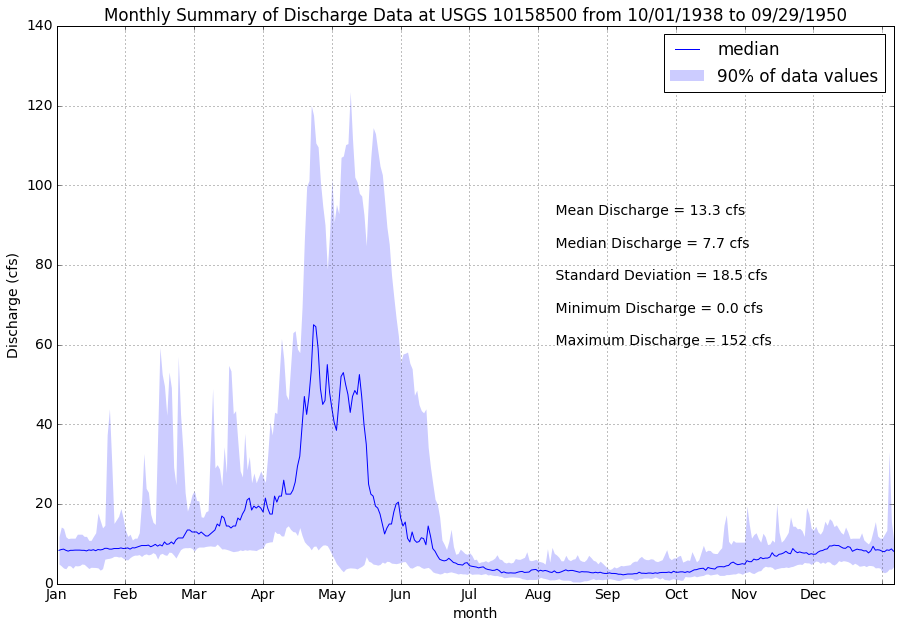

In [12]:
grpd = MainUSGS.groupby(['doy'])['value']
xm = grpd.median().index
ym = grpd.median()
ya = grpd.mean()
y1 = grpd.quantile(q=0.05)
y2 = grpd.quantile(q=0.95)

rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 14
matplotlib.rc('pdf', fonttype=42)

plt.plot(xm,ym, label='median')
#plt.plot(xm,ya, label='mean')
plt.fill_between(xm,y1,y2, label='90% of data values', alpha=0.2, linewidth=0)

plt.title("Monthly Summary of Discharge Data at {:} from {:%m/%d/%Y} to {:%m/%d/%Y}".format('USGS 10158500', 
                                                                                           MainUSGS.index.min(),
                                                                                           MainUSGS.index.max()))
print(ym.median()*365.25*24*60*60*2.296E-5)
minQ = min(MainUSGS['value'])
maxQ = max(MainUSGS['value'])
meanQ = np.mean(MainUSGS['value'])
medianQ = np.median(MainUSGS['value'])
stdQ = np.std(MainUSGS['value'])

plt.legend()
plt.grid()

plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.text(200, 60,
         """
         Mean Discharge = {:0.1f} cfs\n
         Median Discharge = {:0.1f} cfs\n
         Standard Deviation = {:0.1f} cfs\n
         Minimum Discharge = {:0.1f} cfs\n
         Maximum Discharge = {:0.0f} cfs""".format(meanQ,medianQ,stdQ,minQ,maxQ))
plt.ylabel('Discharge (cfs)')
plt.savefig(figplace + 'MainCreekMonthlyHydroGraph.svg')
plt.savefig(figplace + 'MainCreekMonthlyHydroGraph.pdf')

7.7
13.272318576


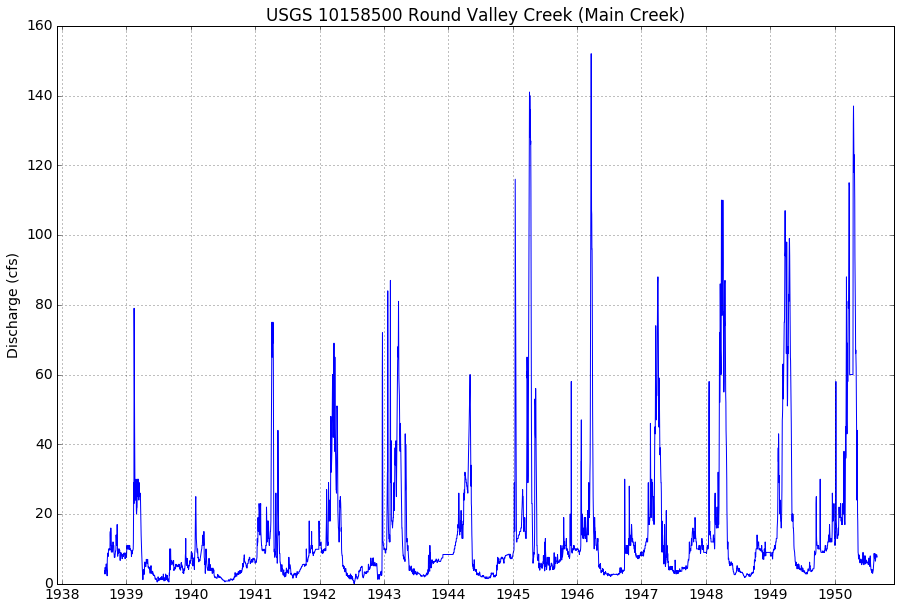

In [13]:
x = MainUSGS.index
y = MainUSGS['value']
plt.plot(x,y)
plt.xlim()
plt.ylabel('Discharge (cfs)')
plt.title('USGS 10158500 Round Valley Creek (Main Creek)')

y1 = MainUSGS['value'].rolling(window=185,center=True).median()
x1 = y1.index
print(MainUSGS['value'].median())
print(MainUSGS['value'].mean())
#plt.plot(x1,y1,color='red')
plt.xlim(pd.datetime(1938,1,1),pd.datetime(1951,1,1))
date_range = pd.date_range('1938-01-01', '1951-01-01', freq='12M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
plt.xticks(date_range)
plt.grid()
plt.savefig(figplace+'MainCreekHydroGraph.svg')
plt.savefig(figplace+'MainCreekHydroGraph.pdf')

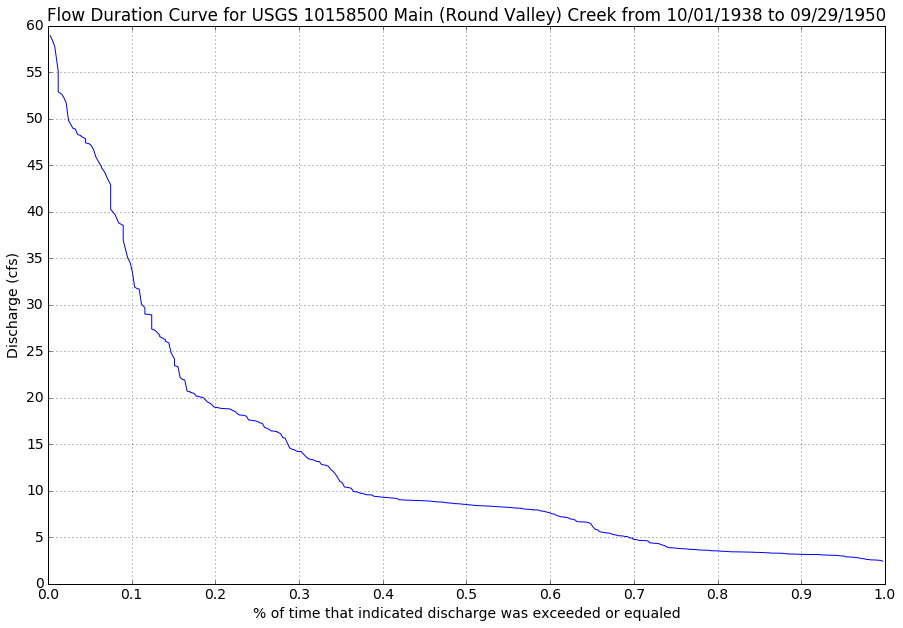

In [14]:
wa.fdc(MainUSGS,'value')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(range(0,65,5))
plt.title('Flow Duration Curve for USGS 10158500 Main (Round Valley) Creek from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(MainUSGS.index.min(),MainUSGS.index.max()))
plt.savefig(figplace + 'fdcMainCreek.svg')
plt.savefig(figplace + 'fdcMainCreek.pdf')

### Deer Creek Res

Read in data

From: http://www.usbr.gov/rsvrWater/faces/rvrOSMP.xhtml

In [15]:
DeerCreek = pd.read_csv(fileplace+'DeerCreekData_Historic.csv', index_col='Date',parse_dates=True)

Add month and day of year columns to data.

In [16]:
DeerCreek.loc[:,'month'] = DeerCreek.index.month
DeerCreek.loc[:,'doy'] = DeerCreek.index.dayofyear

278.0


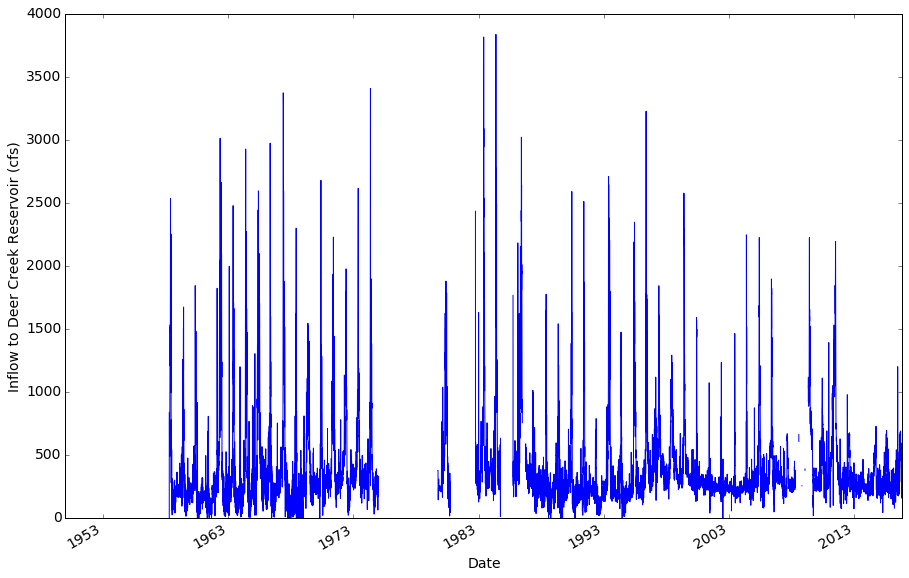

In [17]:
DeerCreek[u'Computed Inflow (cfs)'].plot()
print(DeerCreek[u'Computed Inflow (cfs)'].median())
plt.ylim(0,4000)
plt.ylabel('Inflow to Deer Creek Reservoir (cfs)')

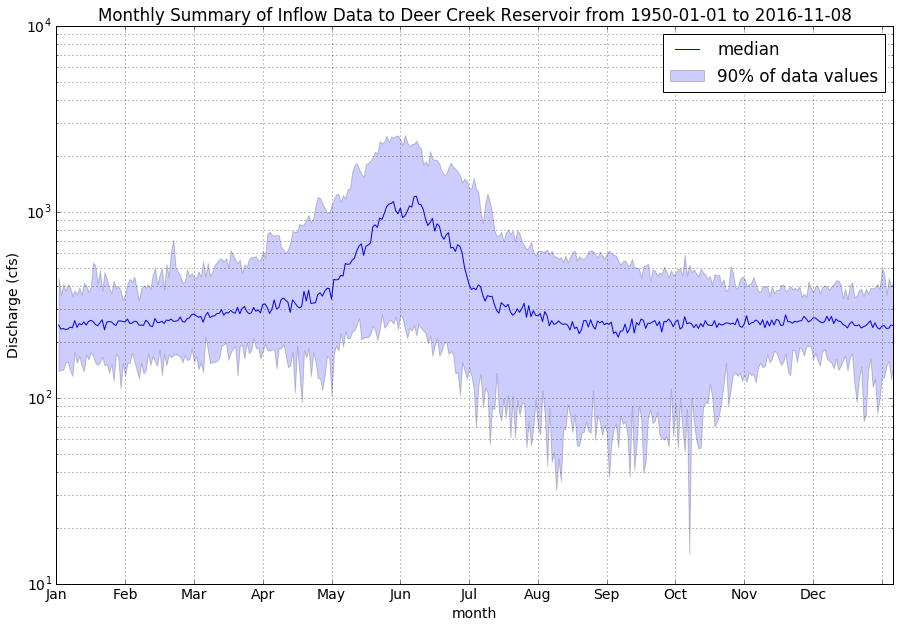

In [18]:
grpd1 = DeerCreek.groupby(['doy'])[u'Computed Inflow (cfs)']
dcx = grpd1.median().index
dcy = grpd1.median()
dcx1 = grpd1.quantile(q=0.05, interpolation='linear').index
dcy1 = grpd1.quantile(q=0.05)
dcx2 = grpd1.quantile(q=0.95).index
dcy2 = grpd1.quantile(q=0.95)

plt.plot(dcx,dcy, label='median')
plt.fill_between(dcx,dcy1,dcy2, label='90% of data values',alpha=0.2)
#plt.plot(dcx,dcy1, label='10th percentile')
#plt.plot(dcx,dcy2, label='90th percentile')

plt.title("Monthly Summary of Inflow Data to %s from %s to %s" %('Deer Creek Reservoir', 
                                                                    datetime.datetime.strftime(DeerCreek[u'Computed Inflow (cfs)'].index.min(),
                                                                                      "%Y-%m-%d"), 
                                                                    datetime.datetime.strftime(DeerCreek[u'Computed Inflow (cfs)'].index.max(),
                                                                                      "%Y-%m-%d")))
plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.yscale('log')
plt.legend()
plt.grid(which='both')

plt.ylabel('Discharge (cfs)')
plt.savefig(figplace+'DeerCreekMonthlyHydroGraph.svg')

0.0292398811085


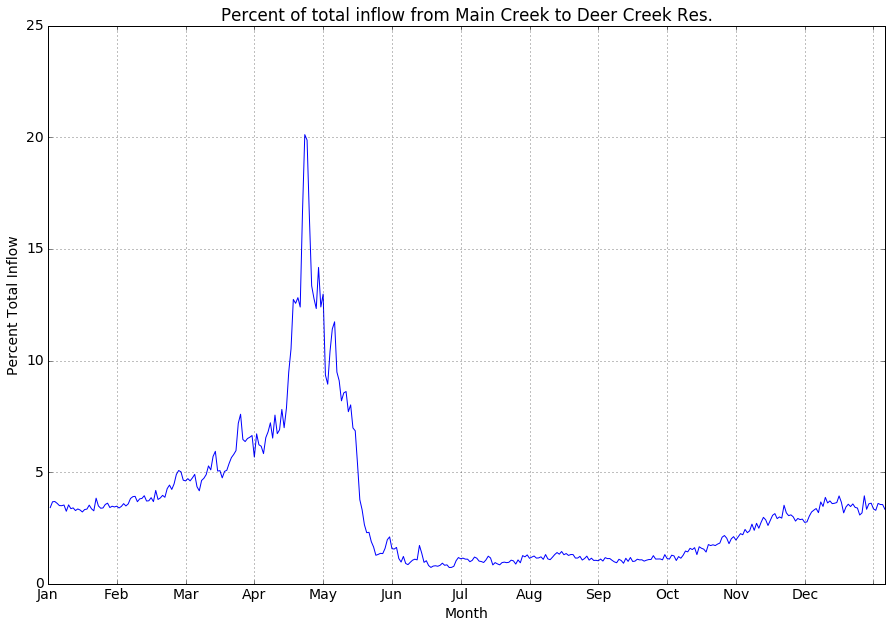

In [19]:
plt.plot(xm, [100*i for i in ym/dcy])
plt.grid()
plt.xlabel('Month')
print(np.median(ym/dcy))
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.ylabel('Percent Total Inflow')
plt.title("Percent of total inflow from Main Creek to Deer Creek Res.")
plt.savefig(figplace+'PercMonthlyDeerCreekInflow.svg')
plt.savefig(figplace+'PercMonthlyDeerCreekInflow.pdf')

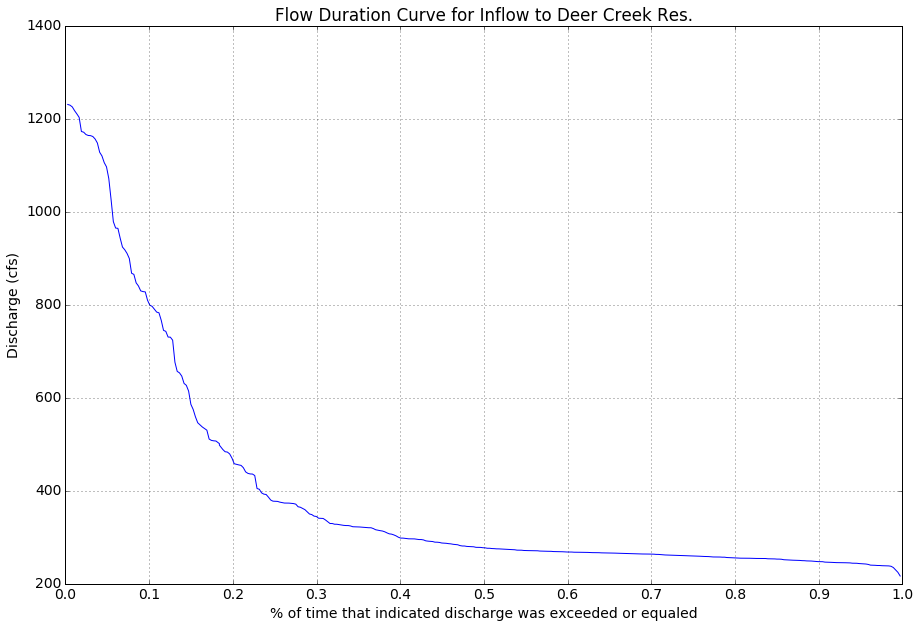

In [20]:
wa.fdc(DeerCreek,u'Computed Inflow (cfs)')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))
#plt.yticks(range(0,65,5))
plt.title('Flow Duration Curve for Inflow to Deer Creek Res.')
plt.savefig(figplace+'fdcDeerCreek.svg')
plt.savefig(figplace+'fdcDeerCreek.pdf')

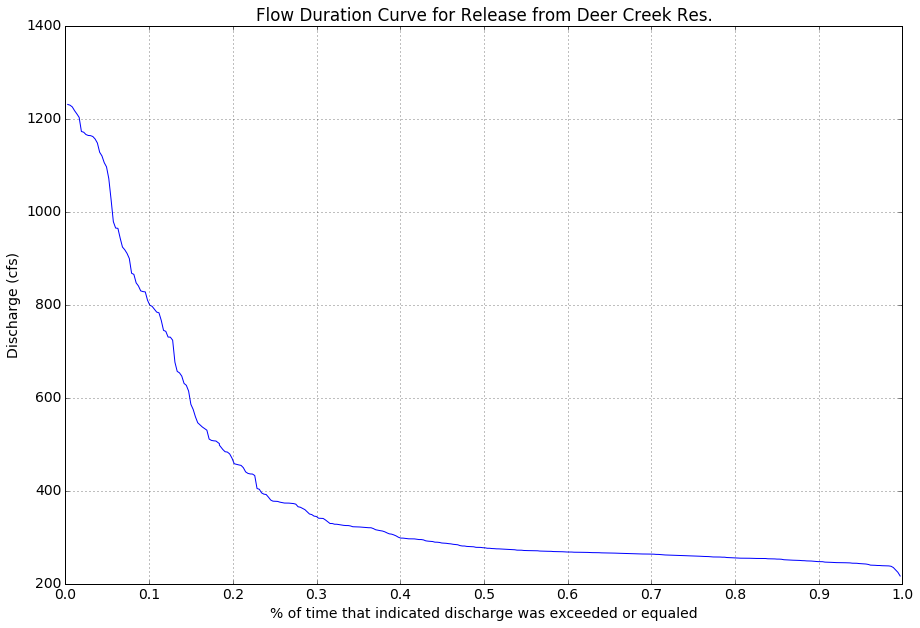

In [21]:
wa.fdc(DeerCreek,u'Computed Inflow (cfs)')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))
#plt.yticks(range(0,65,5))
plt.title('Flow Duration Curve for Release from Deer Creek Res.')
plt.savefig(figplace+'fdcOutDeerCreek.svg')
plt.savefig(figplace+'fdcOutDeerCreek.pdf')

## USGS Stations on Contributaries

connection successful


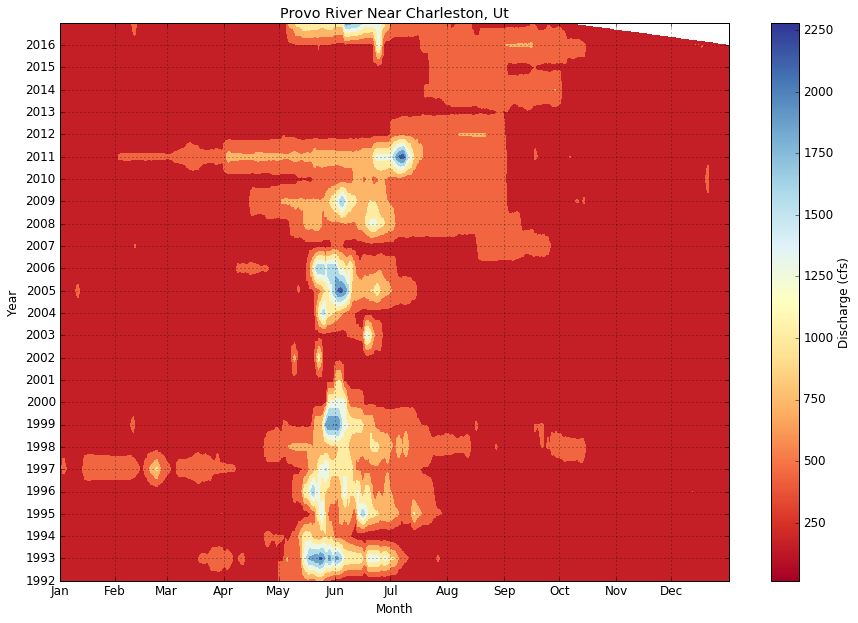

In [22]:
nw = wa.nwis('dv',10155500,'sites',startDT='1992-01-01')
rcParams['font.size'] = 12
nw.nwis_heat_map()

connection successful
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!
Gage height, feet skipped!
2017-10-03 00:00:00


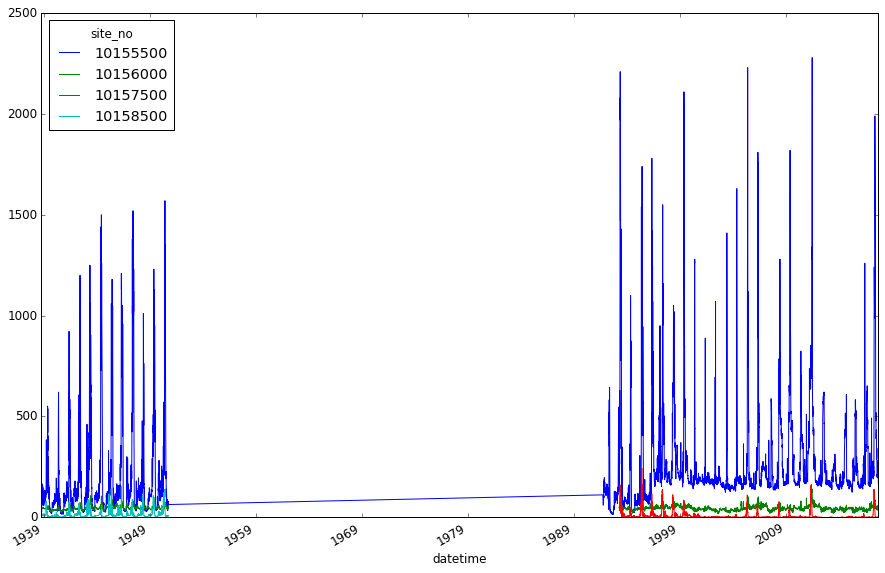

In [23]:
dcstr = wa.nwis('dv',[10155500,10157500,10156000,10158500],'sites')
cont = dcstr.data
cont.drop('qualifiers',axis=1, inplace=True)
cont = cont[cont['value']>0]
contpiv = cont.unstack(level=0)
contpiv = contpiv['value']
contpiv.plot()
contpiv.index = pd.to_datetime(contpiv.index)
print(contpiv['10155500'].last_valid_index())

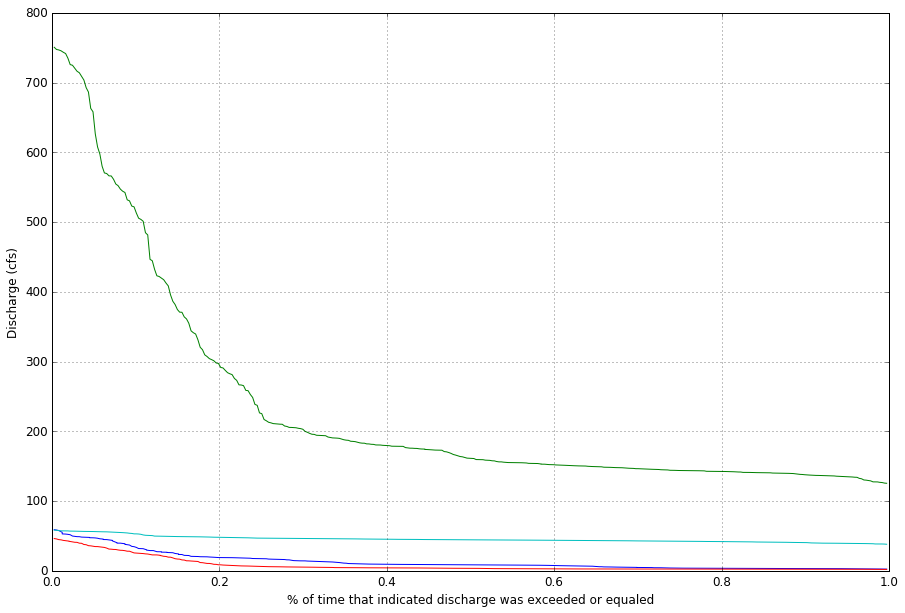

In [24]:
p8500,d8500 = wa.fdc(contpiv,'10158500')
p5500,d5500 = wa.fdc(contpiv,'10155500')
p7500,d7500 = wa.fdc(contpiv,'10157500')
p6000,d6000 = wa.fdc(contpiv,'10156000')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')

### Contributaries

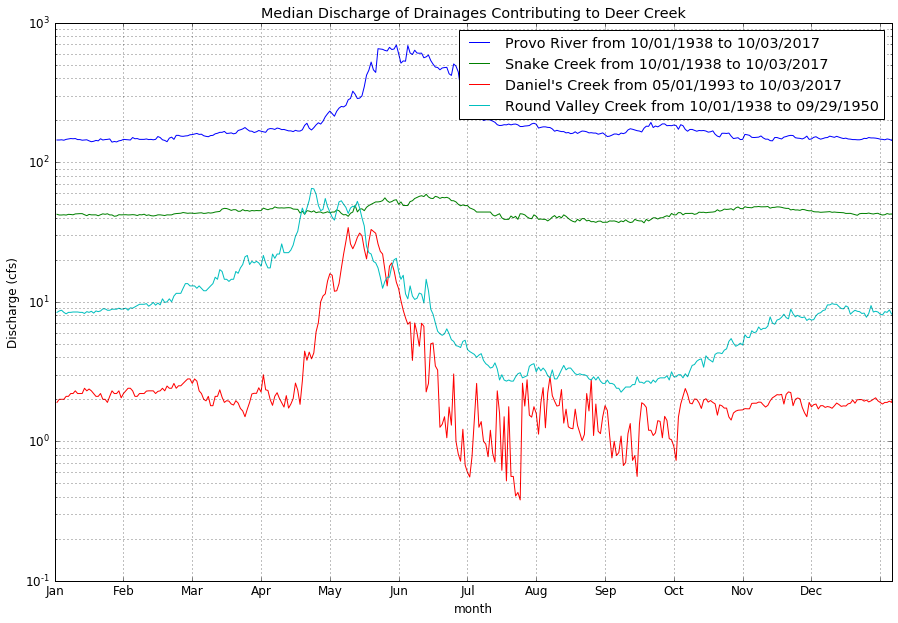

In [25]:
contpiv['doy'] = contpiv.index.dayofyear
statCols = [u'10155500', u'10156000', u'10157500', u'10158500']

LabDict = {'10158500':'Round Valley Creek','10155500':'Provo River',
           '10157500':'Daniel\'s Creek','10156000':'Snake Creek'}


def norm(x):
    return (x-np.mean())


for stat in statCols:
    grpnorm = contpiv.groupby(['doy'])[stat].median()
    plt.plot(grpnorm.index,grpnorm, label="{} from {:%m/%d/%Y} to {:%m/%d/%Y}".format(LabDict[stat],
                                                                                    contpiv[stat].first_valid_index(),
                                                                                    contpiv[stat].last_valid_index()))
    
plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)
plt.yscale('log')
plt.legend()
plt.grid(which='both')
plt.title('Median Discharge of Drainages Contributing to Deer Creek')
plt.ylabel('Discharge (cfs)')
plt.savefig(figplace+'DeerCreekMonthlyHydroGraph.svg')

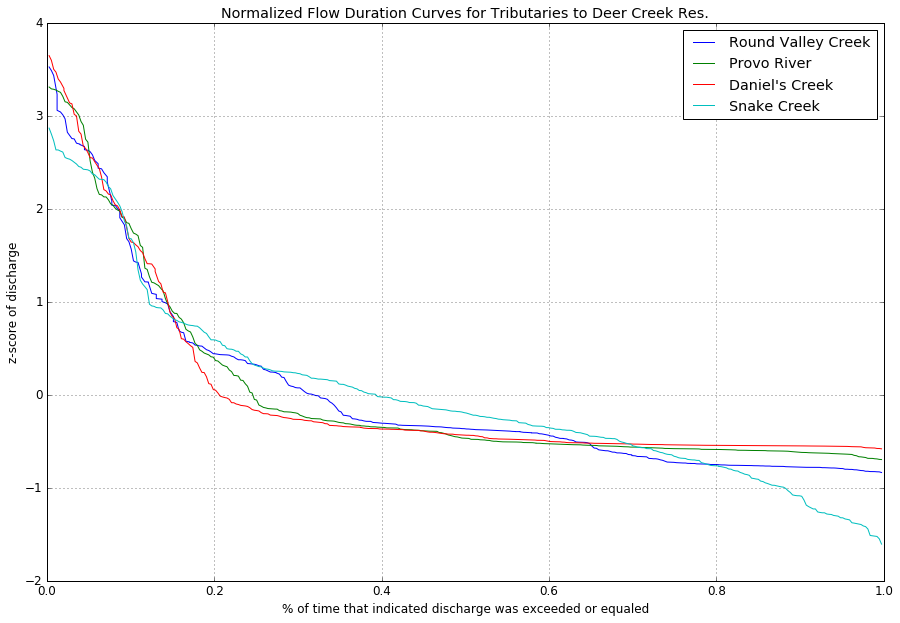

In [26]:
probdata = [p8500,p5500,p7500,p6000] 
flowdata = [d8500,d5500,d7500,d6000]
Labels = ['Round Valley Creek','Provo River','Daniel\'s Creek','Snake Creek']
normdata = []

plt.figure()
plt.title("Normalized Flow Duration Curves for Tributaries to Deer Creek Res.")
for data in flowdata:
    normdata.append((data-np.mean(data))/np.std(data))

for i in range(len(probdata)):
    plt.plot(probdata[i],normdata[i],label=Labels[i])
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.ylabel('z-score of discharge')
plt.legend()
plt.grid()

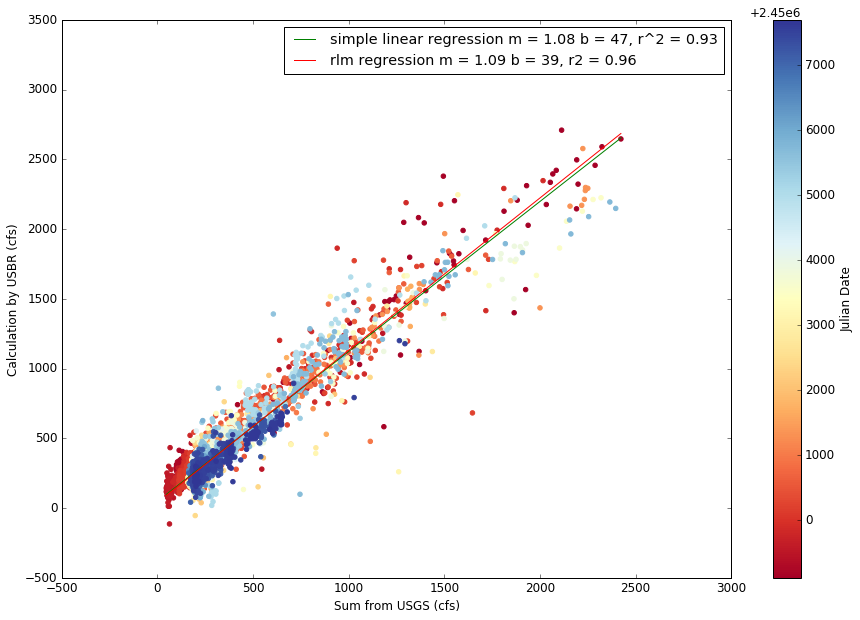

In [27]:
DrCrk = pd.merge(contpiv,DeerCreek,left_index=True,right_index=True)
DrCrk['HeberSum'] = DrCrk[['10155500','10156000','10157500']].apply(lambda x: x[0]+x[1]+x[2],1)

InChk = DrCrk.dropna(subset=['HeberSum','Computed Inflow (cfs)'])
x = InChk['HeberSum']
y = InChk['Computed Inflow (cfs)']
w = InChk.index.to_julian_date()

scatterColor(x,y,w)
plt.xlabel('Sum from USGS (cfs)')
plt.ylabel('Calculation by USBR (cfs)')

In [28]:
DrCrk.columns
DrCrk['USBR_In_afd'] = DrCrk[u'Computed Inflow (cfs)'] * 86400.193536 * 2.29569e-5
DrCrk['USGS_In_afd'] = DrCrk[u'HeberSum'] * 86400.193536 * 2.29569e-5
DrCrk['del_Stor_afd'] = DrCrk[u'Storage (a-f)'].diff()
DrCrk['Tot_Out_afd'] = DrCrk[u'Releases (cfs)'] * 86400.193536 * 2.29569e-5
DrCrk['In_sub_Out_afd'] = DrCrk['USBR_In_afd'] - DrCrk['Tot_Out_afd'] 
DrCrk['doy'] = DrCrk.index.dayofyear
#DrCrk['Tot_Out_cfd'] = DrCrk[[u'Releases (cfs)',u'Power Releases (cfs)']].apply(lambda x: (x[0]+x[1])* 86400.193536,1)

In [29]:
DrCrkStr = DrCrk[DrCrk.index > pd.datetime(1992,10,1)]

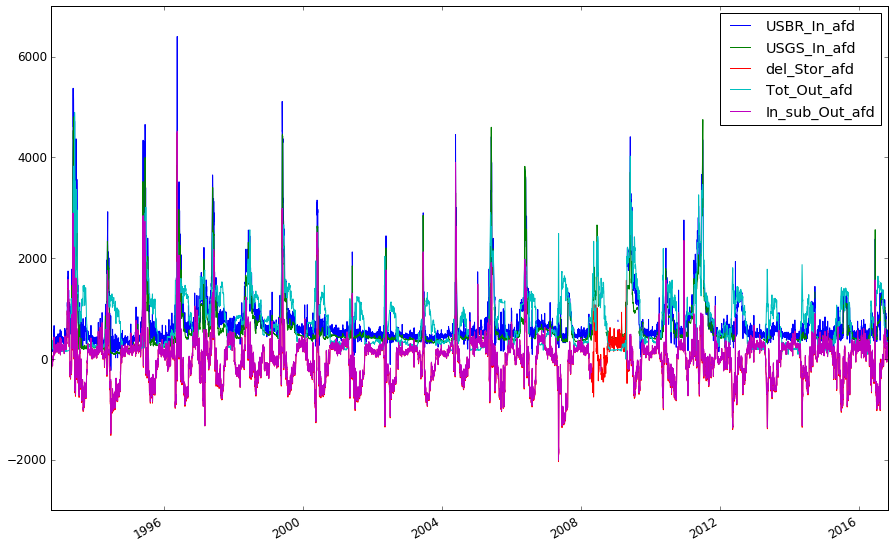

In [30]:
DrCrkStr[['USBR_In_afd','USGS_In_afd','del_Stor_afd','Tot_Out_afd','In_sub_Out_afd']].plot()

In [31]:
grpd1 = DrCrkStr.groupby(['doy']).median()
grpd1

10155500  10156000  10157500  10158500  doy_x  Storage (a-f)  \
doy                                                                 
1       165.5      42.6      1.90       NaN    1.0       112481.5   
2       165.0      42.8      2.00       NaN    2.0       112868.5   
3       163.5      41.8      2.00       NaN    3.0       113353.0   
4       162.5      42.1      2.00       NaN    4.0       113607.5   
5       162.0      41.7      2.10       NaN    5.0       113841.0   
6       159.5      41.9      2.10       NaN    6.0       114118.0   
7       158.5      42.2      2.20       NaN    7.0       114395.0   
8       158.5      42.3      2.20       NaN    8.0       114651.0   
9       162.5      42.9      2.30       NaN    9.0       114886.5   
10      162.0      43.6      2.20       NaN   10.0       115143.0   
11      162.0      43.5      2.20       NaN   11.0       115379.0   
12      165.5      44.0      2.20       NaN   12.0       115566.0   
13      163.0      43.2      2.40       NaN   13.0       115673.5   
14      163.0      43.0      2.30       NaN   14.0       115770.5   
15      163.0      43.3      2.37       NaN   15.0       115921.5   
16      163.5      43.4      2.30       NaN   16.0       116062.0   
17      160.5      42.6      2.20       NaN   17.0       116346.5   
18      162.5      42.6      2.10       NaN   18.0       116531.5   
19      162.0      42.3      2.10       NaN   19.0       116695.0   
20      162.0      42.3      2.20       NaN   20.0       116858.0   
21      162.0      43.0      2.00       NaN   21.0       116989.0   
22      163.0      43.5      2.00       NaN   22.0       117186.5   
23      163.0      43.8      1.90       NaN   23.0       117350.0   
24      164.5      43.8      2.10       NaN   24.0       117491.5   
25      162.5      43.2      2.30       NaN   25.0       117689.0   
26      161.5      43.2      2.20       NaN   26.0       117881.0   
27      164.5      43.0      2.20       NaN   27.0       117836.0   
28      165.5      43.0      2.30       NaN   28.0       118013.5   
29      165.5      42.2      2.05       NaN   29.0       118236.5   
30      165.0      44.0      2.20       NaN   30.0       118314.0   
..        ...       ...       ...       ...    ...            ...   
337     163.5      43.8      1.80       NaN  337.0       105329.5   
338     163.0      44.0      1.83       NaN  338.0       105595.0   
339     161.5      43.5      1.80       NaN  339.0       105789.0   
340     160.0      43.7      1.89       NaN  340.0       106024.5   
341     160.5      43.6      1.90       NaN  341.0       106228.5   
342     159.5      42.5      1.87       NaN  342.0       106474.0   
343     159.5      42.9      1.80       NaN  343.0       106644.5   
344     159.5      43.0      1.80       NaN  344.0       106748.5   
345     159.5      42.7      1.80       NaN  345.0       106916.0   
346     162.0      42.5      1.90       NaN  346.0       107052.5   
347     162.5      42.5      1.90       NaN  347.0       107220.0   
348     163.5      43.0      2.10       NaN  348.0       107335.5   
349     163.0      42.5      1.90       NaN  349.0       107461.5   
350     163.5      42.0      2.00       NaN  350.0       107615.5   
351     166.5      41.6      2.00       NaN  351.0       107811.0   
352     164.0      42.5      2.00       NaN  352.0       108006.5   
353     165.0      43.0      1.98       NaN  353.0       108264.5   
354     164.5      42.9      2.00       NaN  354.0       108513.5   
355     167.0      44.0      2.00       NaN  355.0       108868.5   
356     166.5      43.0      2.00       NaN  356.0       109035.0   
357     166.0      44.0      2.00       NaN  357.0       109295.5   
358     162.0      43.7      2.10       NaN  358.0       109558.5   
359     162.5      43.5      2.00       NaN  359.0       109644.0   
360     160.5      43.7      1.90       NaN  360.0       110115.0   
361     161.0      44.2      1.85       NaN  361.0       110463.5   
362

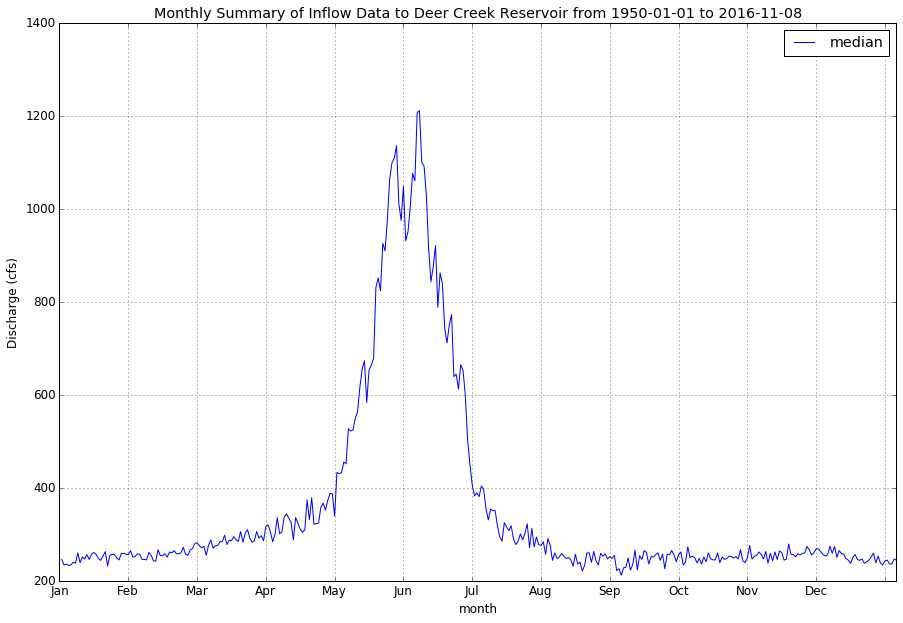

In [32]:
['USBR_In_afd','USGS_In_afd','del_Stor_afd','Tot_Out_afd','In_sub_Out_afd']
grpd1 = DrCrkStr.groupby(['doy']).median()
dcx1 = grpd1.median().index
dcy1 = grpd1.median()
dcx1 = grpd1.quantile(q=0.1, interpolation='linear').index
dcy1 = grpd1.quantile(q=0.1)
dcx2 = grpd1.quantile(q=0.90).index
dcy2 = grpd1.quantile(q=0.90)

plt.plot(dcx,dcy, label='median')
#plt.plot(dcx,dcy1, label='10th percentile')
#plt.plot(dcx,dcy2, label='90th percentile')

plt.title("Monthly Summary of Inflow Data to %s from %s to %s" %('Deer Creek Reservoir', 
                                                                    datetime.datetime.strftime(DeerCreek[u'Computed Inflow (cfs)'].index.min(),
                                                                                      "%Y-%m-%d"), 
                                                                    datetime.datetime.strftime(DeerCreek[u'Computed Inflow (cfs)'].index.max(),
                                                                                      "%Y-%m-%d")))
plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)

plt.legend()
plt.grid()

plt.ylabel('Discharge (cfs)')
plt.savefig(figplace+'DeerCreekMonthlyHydroGraph.svg')

## DEQ Data

### DEQ Flow Data

Import DEQ transducer data from file provided by Sandy Wingert.

In [553]:
raw_DEQ0 = pd.read_excel(fileplace+"Main Creek Continuous Temperature Data.xlsx",sheetname='5913460_040914_042215', 
                         skiprows=71, index_col='Date and Time',parse_cols=4)
raw_DEQ2 = pd.read_excel(fileplace+"042215_062116_5910619.xlsx",skiprows=71, index_col='Date and Time',parse_cols=4)


In [554]:
raw_DEQ = pd.concat([raw_DEQ2,raw_DEQ0])
raw_DEQ.sort_index(inplace=True)
raw_DEQ.drop_duplicates(inplace=True)

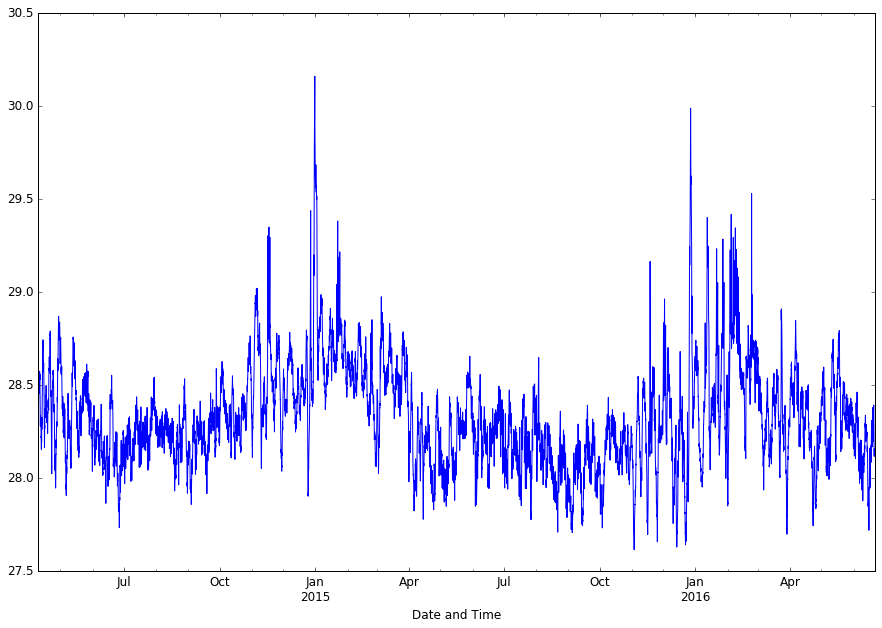

In [555]:
raw_DEQ.columns = [i.strip() for i in raw_DEQ.columns]
raw_DEQ['dDepth'] = raw_DEQ['Depth (ft)'].diff()
DEQ = raw_DEQ.groupby(level=0).first()
DEQdepth = wa.hourly_resample(DEQ, minutes=60)
DEQdepth['Depth (ft)'].plot()

Import barometric data from Heber Valley airport Mesowest station.

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\wellapplication\transport.py:810: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



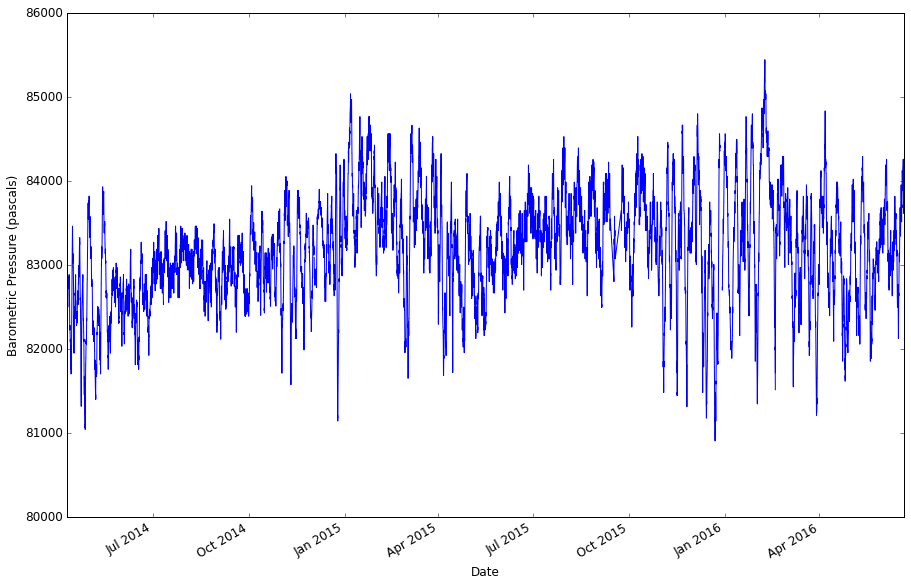

In [556]:
station = 'K36U'
token = "1ab92e63dd924c6189e6d5e1015c2645"
begdate1 = datetime.datetime.strftime(DEQdepth.index[0],"%Y%m%d%H%M")
enddate1 = datetime.datetime.strftime(DEQdepth.index[int(len(DEQdepth)/2)],"%Y%m%d%H%M")
enddate2 = datetime.datetime.strftime(DEQdepth.index[-1],"%Y%m%d%H%M")
begdate2 = datetime.datetime.strftime(DEQdepth.index[int(len(DEQdepth)/2)],"%Y%m%d%H%M")

def getbaro(begdate,enddate,station,token):
    addrs = 'https://api.mesowest.net/v2/stations/timeseries?token={:}&stid={:}&state=ut&start={:}&end={:}&units=pres|mb&output=csv'
    html = addrs.format(token,station,begdate,enddate)
    baro = pd.read_csv(html,skiprows=8,usecols=[1,2,15],index_col=0,parse_dates=True,names=['datetime','pressure_pascals','precip_mm'])
    return baro

baro1 = getbaro(begdate1,enddate1,station,token)
baro2 = getbaro(begdate2,enddate2,station,token)

baro = pd.concat([baro1,baro2])


baro = wa.jumpfix(baro,'pressure_pascals',threashold=10000)
baro['pressure_pascals'].plot()
barores = wa.hourly_resample(baro, minutes=60)

barores['baro (ft)'] = barores['pressure_pascals']*0.000334562
barores['d_baro_ft'] = barores['baro (ft)'].diff()
plt.ylabel('Barometric Pressure (pascals)')
plt.xlabel('Date')

In [557]:
DEQfl = pd.concat([barores,DEQdepth], axis=1)
DEQfl.sort_index(inplace=True)
DEQfl.dropna(subset=['dDepth','d_baro_ft'],how='any',inplace=True)

Check for lag between Heber Valley weather station and Round Valley transducer data.

In [558]:
datax = DEQfl['d_baro_ft']
datay = DEQfl['dDepth']

xcov = [crosscorr(datax, datay, lag=i) for i in range(60)]
print(xcov[:20])

[0.034507667016954763, 0.045567520506961501, 0.058903490358034147, 0.11100001921475697, 0.14843340794523485, 0.20292215628610474, 0.26724482261415888, 0.28133666813877628, 0.19396061766055653, 0.11385889513114833, 0.048201285864344058, 0.010868420950751693, -0.027220439221214653, -0.044407060358732521, -0.02854907335510002, -0.01764416746759264, -0.0023333992049578232, -0.0018149453168446281, -0.0017697907035847101, -0.010006038291525304]


8.49369572823 0.712349118236


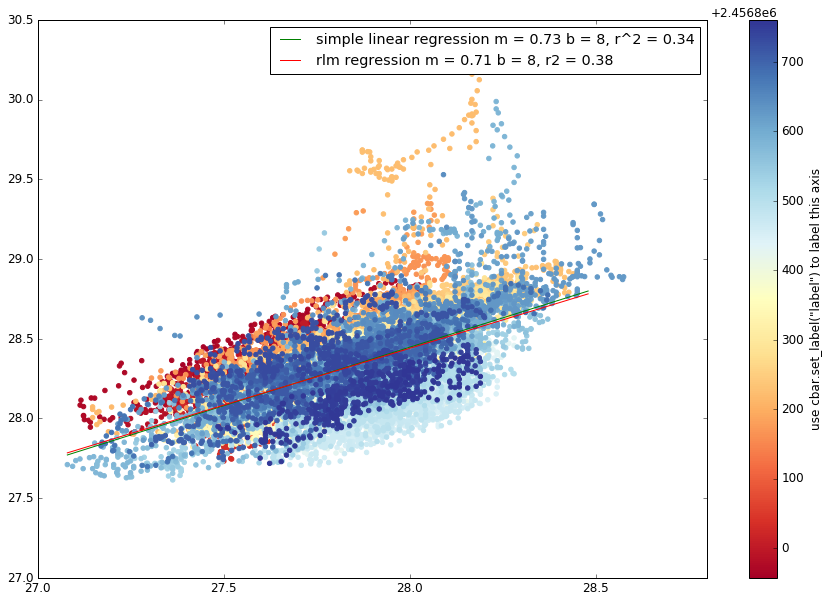

In [559]:
x0 = DEQfl['baro (ft)']
y = DEQfl['Depth (ft)']
w = DEQfl.index.to_julian_date()

slope, const = wa.scatterColor(x0, y, w)
print(const, slope)

def pfilt(x):
    '''
    filtered out measured pressure if temperature is below 0
    '''
    if x[1] <= 0:
        return np.nan
    else:
        return x[0]

DEQfl['filt_Press']  = DEQfl[['Depth (ft)','Temperature (C)']].apply(lambda x: pfilt(x), 1)

DEQfl['waterDepth'] = DEQfl[['baro (ft)','Depth (ft)']].apply(lambda x: x[1] - (x[0]*slope + const),1)

In [560]:
awqmsFile = fileplace + r'Standard Export 16567.xlsx'
awqms = pd.read_excel(awqmsFile,skiprows=1)

dropcols = []
for column in list(awqms.describe().columns):
    if awqms.describe().loc['count',column] == 0:
        dropcols.append(column)
        
awqms.drop(dropcols, axis=1, inplace=True)

awqms['datetime'] = awqms[["Activity Start Date","Activity Start Time"]].apply(lambda x: pd.to_datetime(str(x[0])[:11]+str(x[1])[-8:],
                                                                                                                  format='%Y-%m-%d %H:%M:%S',
                                                                                                                  errors='coerce'),1)
flowvalues = awqms[awqms[u'Characteristic Name']==u'Flow']
flowvalues.set_index('datetime',inplace=True)
flowvalues2 = flowvalues[(flowvalues['Monitoring Location Name']==u'MAIN CK AB DEER CK RES AT US 189 XING')|(flowvalues['Monitoring Location Name']==u'Main Creek 0.4 mile AB U.S. Highway 189 at driveway bridge')]
flowvalues3 =flowvalues2[(flowvalues2.index < pd.datetime(2016,6,22))&(flowvalues2.index > pd.datetime(2014,4,20))]

In [568]:
MFQ

[1.2552242813381547,
 1.1119861166287386,
 1.3789956511126071,
 1.2343511449607227,
 1.1709676020344304,
 1.0286754178673085,
 1.2504411607325672,
 1.1225836771989215,
 0.79933805670427915,
 0.99867358899127723,
 1.0136437110370693,
 0.8992423044053055,
 0.740166680493207,
 0.54799968620546124,
 0.67993000354422506,
 0.7670603208829796,
 1.4032007814676426,
 1.4757069483527694,
 0.9659292670292956,
 1.0203416275024928,
 1.0562418049554942,
 0.70858825497228395,
 1.2373594030737998,
 1.2484290857350437,
 0.80407769336702373,
 0.81370733380296656,
 0.84774143477740083,
 1.0270706568539758,
 1.0217715264818885,
 1.0302844713366142]

In [561]:
def eqn(x, a,b,c):
    return a*x+b+c

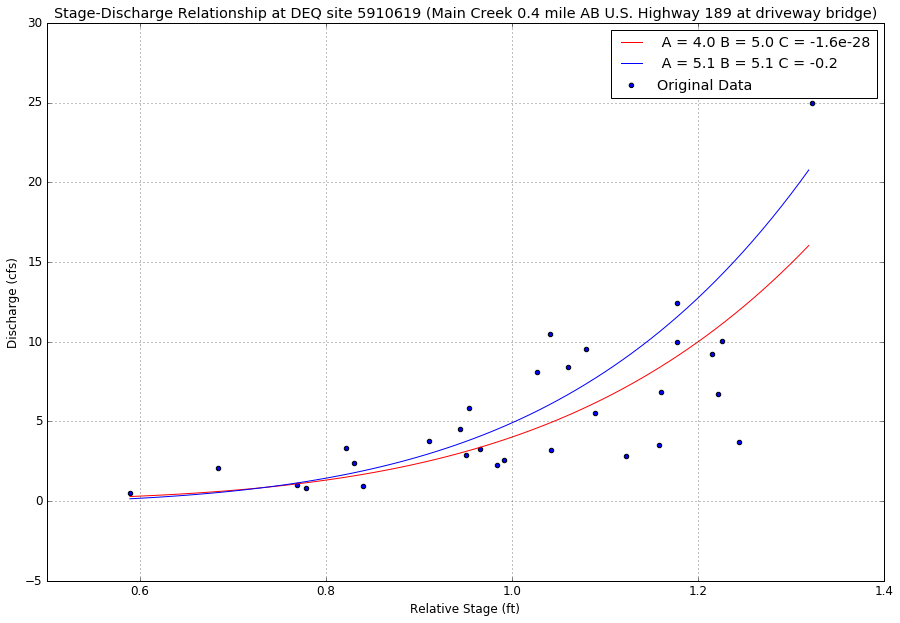

In [616]:
stage = flowvalues3['Result Value']
Q = DEQfl[(DEQfl['waterDepth']<0.4)&(DEQfl['waterDepth']<0.4)]['waterDepth'].rolling(window=24).mean()


def func(x, a, b, c):
    return a*(x)**(b) + c



MFQ = []

for j in stage.index:
    MFQ.append(wa.transport.fcl(Q, j)+1)
    
yn = stage.values
x = MFQ

bounds = ([0.75,5.0, -10.0],[30.0,10.0,0.0]) # ([1.0,0.0,1.0],[50.0, 5.0, 10.0])


popt, pcov = curve_fit(func, x, yn, bounds=bounds, max_nfev = 800000) #, method='trf')

sterr = np.sqrt(np.diag(pcov))


equation = 'Fitted Curve ' + r'$f(x)= (A \dot (x)^{B} + C)$ '
eqlab = ' A = {:.2} B = {:.2} C = {:.2}'


plt.figure()
plt.scatter(x, yn, label="Original Data")
xb = np.arange(np.min(x),np.max(x),0.01)
plt.plot(xb, [func(i, popt[0],popt[1],popt[2]) for i in xb], 'r-', label= eqlab.format(popt[0],popt[1],popt[2]))

p = [5.1,5.1,-0.2]
plt.plot(xb, [func(i, *p) for i in xb], 'b-', label= eqlab.format(*p))


plt.legend(loc=1,scatterpoints=1)
plt.ylabel('Discharge (cfs)')
plt.xlabel('Relative Stage (ft)')
plt.grid()
plt.title('Stage-Discharge Relationship at DEQ site 5910619 (Main Creek 0.4 mile AB U.S. Highway 189 at driveway bridge)')
plt.savefig(figplace + 'stageDischarge.svg')
plt.savefig(figplace + 'stageDischarge.pdf')


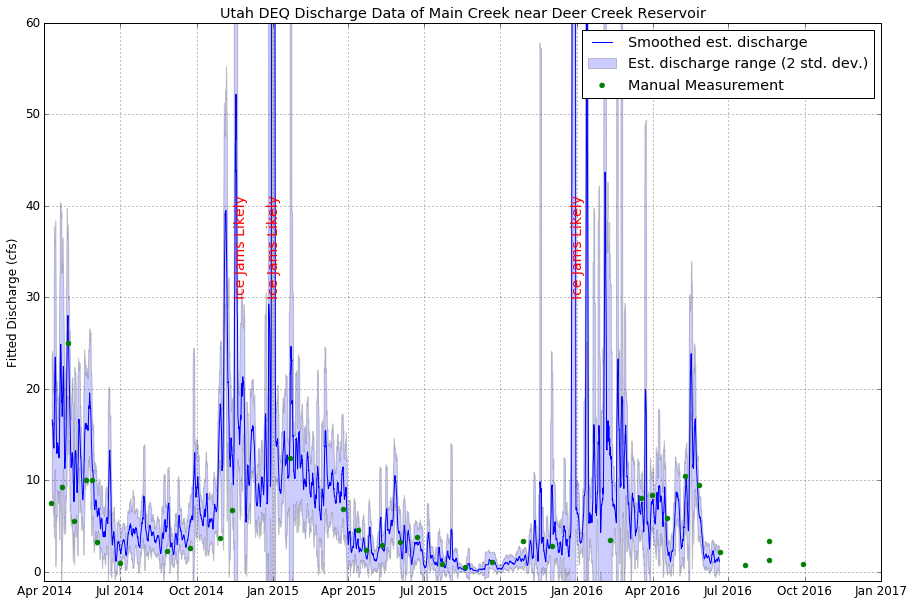

In [617]:
#p = popt
x = flowvalues2.index
y = flowvalues2['Result Value']
x1 = DEQfl.index
y1 = DEQfl.waterDepth
DEQfl['flow'] = DEQfl['waterDepth'].apply(lambda x: func(x+1.0, *p), 1)

y3 = DEQfl['flow'].rolling(50,center=True).mean()
y2 = y3+DEQfl['flow'].rolling(50,center=True).std()*2
y4 = y3-DEQfl['flow'].rolling(50,center=True).std()*2

plt.fill_between(x1,y2,y4,alpha=.2,zorder=1, label='Est. discharge range (2 std. dev.)')
plt.plot(x1,y3, label='Smoothed est. discharge')
plt.scatter(x, y, zorder=10, color='green', label='Manual Measurement')
plt.xlim('4/1/2014','1/1/2017')
plt.ylim(-1,60)
plt.ylabel('Fitted Discharge (cfs)')
plt.grid()
plt.title('Utah DEQ Discharge Data of Main Creek near Deer Creek Reservoir')
plt.text('11/15/2014',40,'Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.text('12/25/2014',40,'Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.text('12/25/2015',40,'Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.legend(scatterpoints=1)

plt.savefig(figplace + 'estDischarge.svg')

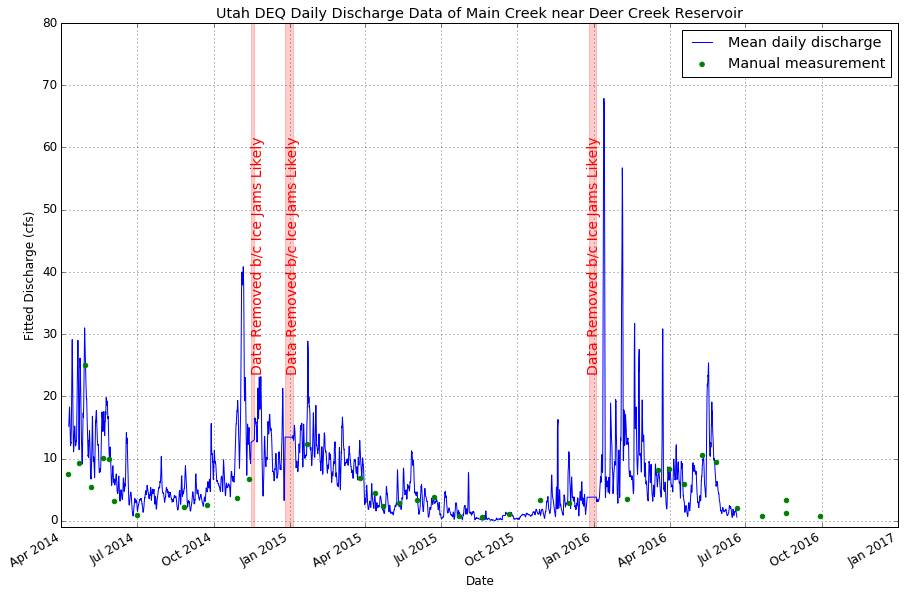

In [618]:
DEQflClip = DEQfl[(DEQfl.index < pd.datetime(2014,11,15))|(DEQfl.index > pd.datetime(2014,11,19))]
DEQflClip = DEQflClip[(DEQflClip.index < pd.datetime(2014,12,26))|(DEQflClip.index > pd.datetime(2015,1,4))]
DEQflClip = DEQflClip[(DEQflClip.index < pd.datetime(2015,12,24))|(DEQflClip.index > pd.datetime(2016,1,4))]
DEQflClip['flow'].rolling(24,center=True).mean().plot(label='Mean daily discharge')

x = flowvalues2.index
y = flowvalues2['Result Value']
plt.scatter(x, y, zorder=10, color='green', label='Manual measurement')
plt.axvspan('11/15/2014','11/19/2014',color='red',alpha=0.2)
plt.axvspan('12/26/2014','1/4/2015',color='red',alpha=0.2)
plt.axvspan('12/26/2015','1/4/2016',color='red',alpha=0.2)
plt.xlim('4/1/2014','1/1/2017')
plt.ylim(-1,80)
plt.ylabel('Fitted Discharge (cfs)')
plt.xlabel('Date')
plt.grid()
plt.title('Utah DEQ Daily Discharge Data of Main Creek near Deer Creek Reservoir')
plt.text('11/15/2014',60,'Data Removed b/c Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.text('12/27/2014',60,'Data Removed b/c Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.text('12/24/2015',60,'Data Removed b/c Ice Jams Likely',rotation=90, fontsize=14, color='red')
plt.legend(scatterpoints=1)
plt.savefig(figplace + 'estDailyDEQDischarge.svg')
plt.savefig(figplace + 'estDailyDEQDischarge.pdf')

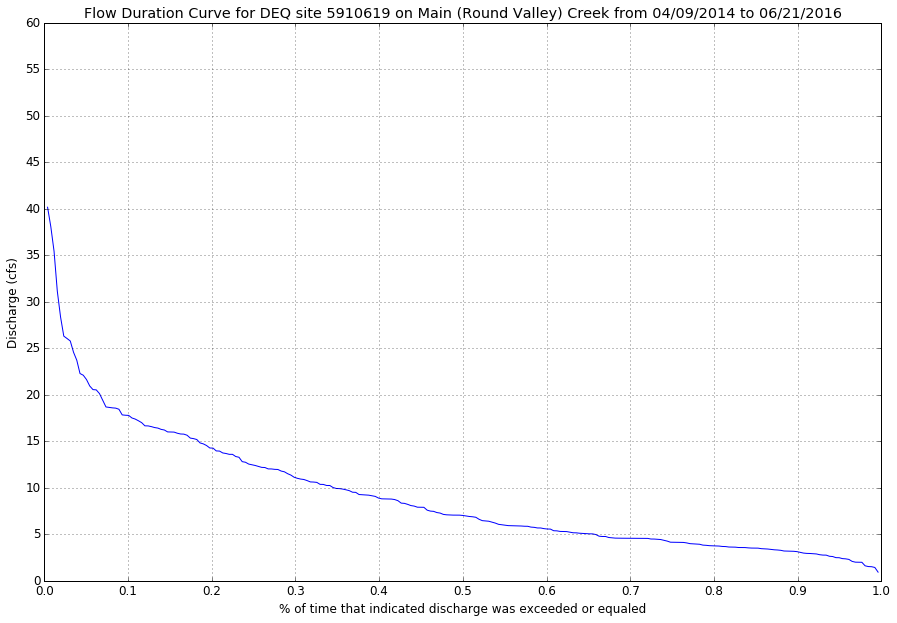

In [619]:
wa.fdc(DEQflClip, 'flow')
plt.grid()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(range(0,65,5))
plt.title('Flow Duration Curve for DEQ site 5910619 on Main (Round Valley) Creek from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(DEQflClip.index.min(),DEQflClip.index.max()))
plt.savefig(figplace + 'fdcMainCreekDEQ.svg')
plt.savefig(figplace + 'fdcMainCreekDEQ.svg')

In [620]:
def fdc_simple(df, site, begyear=1900, endyear=2018, normalizer=1, plot=True):
    '''
    Generate flow duration curve for hydrologic time series data

    PARAMETERS:
        df = pandas dataframe of interest; must have a date or date-time as the index
        site = pandas column containing discharge data; must be within df
        begyear = beginning year of analysis; defaults to 1900
        endyear = end year of analysis; defaults to 2015
        normalizer = value to use to normalize discharge; defaults to 1 (no normalization)

    RETURNS:
        matplotlib plot displaying the flow duration curve of the data

    REQUIRES:
        numpy as np
        pandas as pd
        matplotlib.pyplot as plt
        scipy.stats as sp
    '''
    # limit dataframe to only the site
    df = df[[site]]

    # filter dataframe to only include dates of interest
    data = df[(df.index.to_datetime() > pd.datetime(begyear,1,1))&(df.index.to_datetime() < pd.datetime(endyear,1,1))]

    # remove na values from dataframe
    data = data.dropna()

    # take average of each day of year (from 1 to 366) over the selected period of record
    data['doy']=data.index.dayofyear
    dailyavg = data[site].groupby(data['doy']).mean()
    dailymed = data[site].groupby(data['doy']).median()
    dailystdp = data[site].groupby(data['doy']).mean() + data[site].groupby(data['doy']).std()*2
    dailystdm = data[site].groupby(data['doy']).mean() - data[site].groupby(data['doy']).std()*2
    data = np.sort(dailyavg)
    datastdp = np.sort(dailystdp)
    datastdm = np.sort(dailystdm)
    datastdm = [0 if i < 0 else i for i in datastdm]
    datamed = np.sort(dailymed)
    ## uncomment the following to use normalized discharge instead of discharge
    #mean = np.mean(data)
    #std = np.std(data)
    #data = [(data[i]-np.mean(data))/np.std(data) for i in range(len(data))]
    data = [(data[i])/normalizer for i in range(len(data))]

    # ranks data from smallest to largest
    ranks = sp.rankdata(data, method='average')

    # reverses rank order
    ranks = ranks[::-1]

    # calculate probability of each rank
    prob = [(ranks[i]/(len(data)+1)) for i in range(len(data)) ]

    # plot data via matplotlib
    if plot == True:
        plt.plot(prob,data,label=site+' '+str(begyear)+'-'+str(endyear))
    else:
        pass
    return prob, data, datastdp, datastdm, datamed

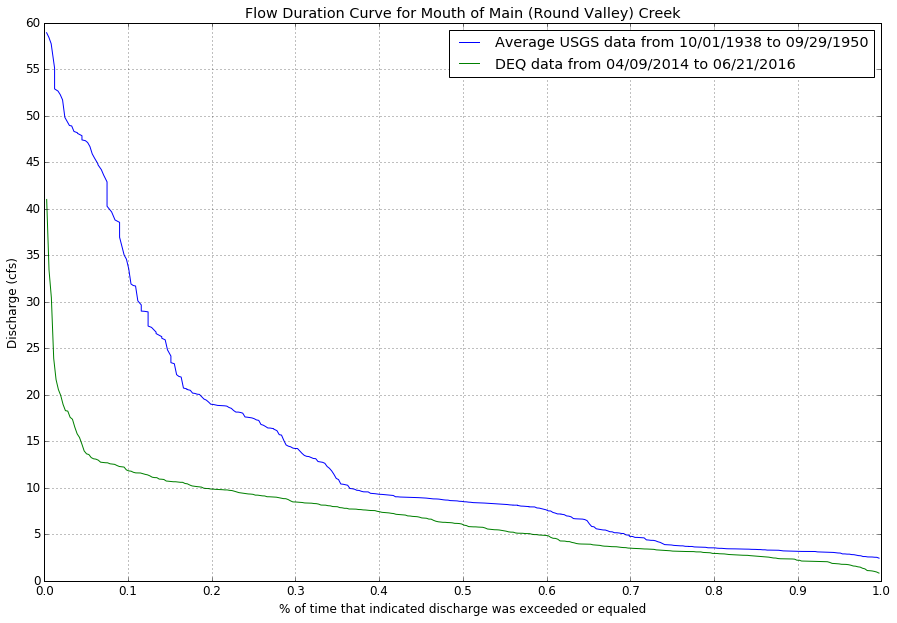

In [621]:
p1, d1, stdp1, stdm1, med1 = fdc_simple(MainUSGS,'value',plot=False)
p2, d2, stdp2, stdm2, med2 = fdc_simple(DEQflClip,'flow',plot=False)

rcParams['figure.figsize'] = 15, 10
plt.title('Flow Duration Curve for Mouth of Main (Round Valley) Creek')
plt.plot(p1,d1,label='Average USGS data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(MainUSGS.index.min(),MainUSGS.index.max()))
plt.plot(p2,d2,label='DEQ data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(DEQflClip.index.min(),DEQflClip.index.max()))
#plt.fill_between(p1,stdm1,stdp1,alpha=.3)
plt.grid()
plt.legend()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))

plt.yticks(range(0,65,5))
plt.savefig(figplace + 'fdc_all_MainCreek.svg')
plt.savefig(figplace + 'fdc_all_MainCreek.pdf')

In [65]:
DEQflClip['doy'] = DEQflClip.index.dayofyear

### DEQ Long-Term Flow

In [774]:
DEQ_long_flow = pd.read_excel(fileplace+'flow_check_wqp.xlsx','Sheet1')
DEQ_long_flow.set_index('datetime',inplace=True)
DEQ_long_flow.drop_duplicates(inplace=True)

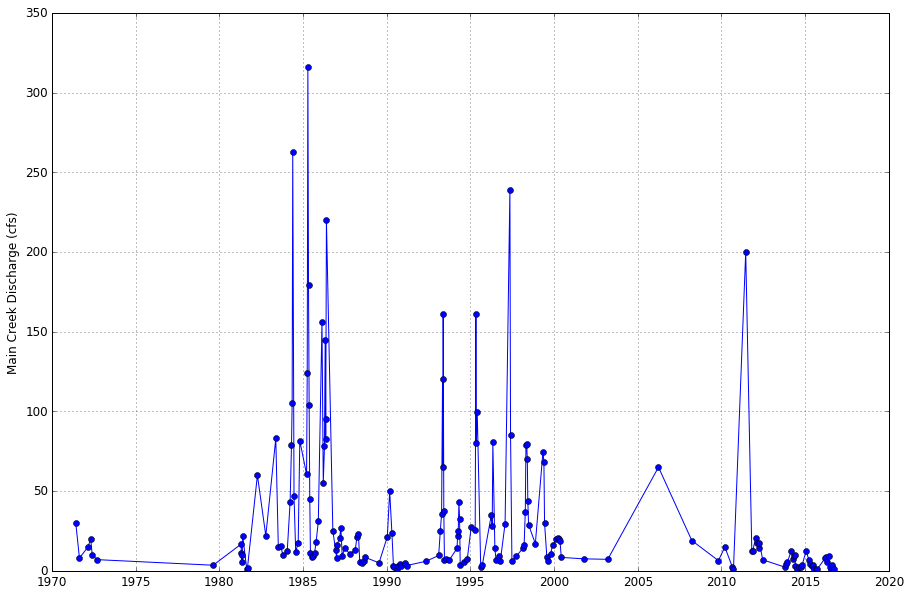

In [775]:
plt.figure()
x = DEQ_long_flow.index
y = DEQ_long_flow.Flow_cfs
y0 = y*60.3307
plt.plot(x,y,'o-')
plt.ylabel('Main Creek Discharge (cfs)')
plt.xlim('1/1/1970','1/1/2020')
plt.grid()
plt.savefig(figplace+'DEQ_long_term.pdf')
#plt.xticks()



In [792]:
stats

medQ       avgQ       stdQ
datetime                              
1         18.300  18.462500   7.556442
2         14.400  33.582857  54.195732
3         17.600  23.754045  18.433074
4         25.500  46.061600  63.134784
5         79.500  81.175714  70.303023
6         10.000  26.075263  44.669696
7          7.050   7.155917   5.011887
8          3.035   4.398750   3.877944
9          5.200   5.946429   4.849486
10         9.900  15.195600  19.520463
11        12.500  10.570000   6.665546
12        12.800  16.493333  13.057800

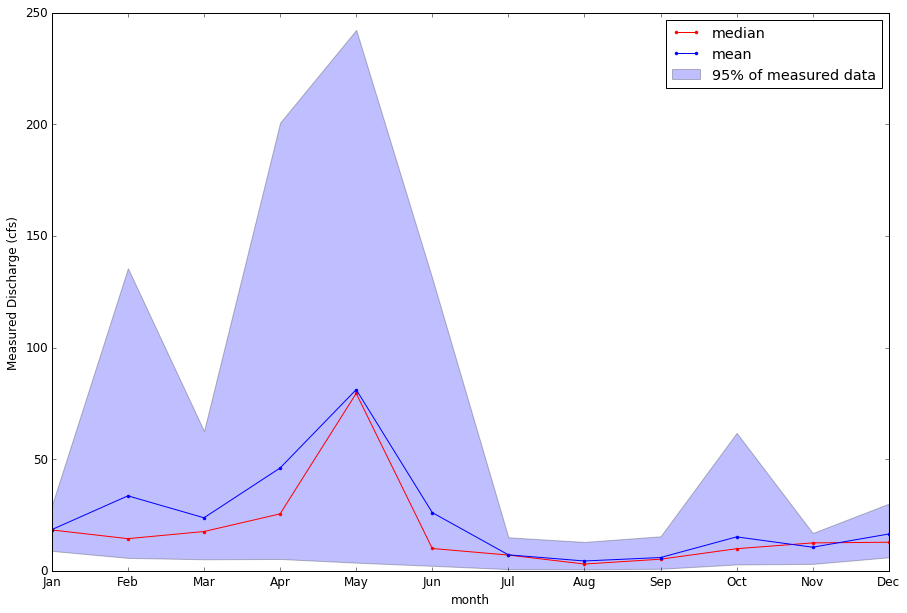

In [802]:
medQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).median()
avgQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).mean()
stdQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).std()
lowQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).agg(lambda x: np.percentile(x,2.5))
highQ = DEQ_long_flow.groupby(DEQ_long_flow.index.month).agg(lambda x: np.percentile(x,97.5))
stats = pd.concat([medQ,avgQ,stdQ,lowQ,highQ],axis=1)
stats.columns = ['medQ','avgQ','stdQ','lowQ','highQ']


plt.figure()
plt.plot(medQ.index,medQ,'r.-',label='median')
plt.plot(avgQ.index,avgQ,'b.-',label= 'mean')
plt.fill_between(stats.index, stats.lowQ, stats.highQ,alpha=0.25,label='95% of measured data')
plt.xlim(1,12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13),months)
plt.xlabel('month')
plt.ylabel('Measured Discharge (cfs)')
plt.legend()

### DEQ Temperature Data

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

using a dict on a Series for aggregation
is deprecated and will be removed in a future version



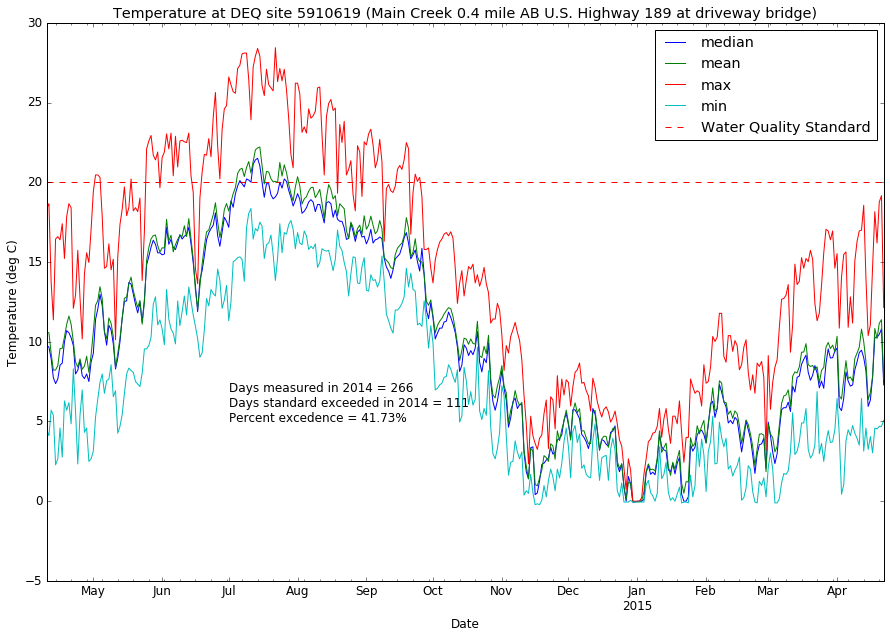

In [68]:
fileplace= 'E:/Google Drive/WORK/Round_Valley/Data/Hydrology_Data/'
raw_DEQ = pd.read_excel(fileplace+"Main Creek Continuous Temperature Data.xlsx", skiprows=71, index_col='Date and Time')
raw_DEQ.columns = [i.strip() for i in raw_DEQ.columns]
dailyDEQ = raw_DEQ.groupby(pd.TimeGrouper('D'))['Temperature (C)'].agg({'max':max, 'mean':np.mean, 'median':np.median, 'min':min})
dailyDEQ.drop(pd.datetime(2014,4,9), axis=0, inplace=True)
dailyDEQ['Threshold'] = dailyDEQ['max'].apply(lambda x: int(x > 20), 1)
dailyDEQ['CumulThresh'] = dailyDEQ['Threshold'].cumsum()
dailyDEQ[['median', 'mean','max','min']].plot()
plt.hlines(20,dailyDEQ.index[0],dailyDEQ.index[-1], label='Water Quality Standard', color='red', linestyles='dashed')
plt.legend()
plt.ylabel('Temperature (deg C)')
plt.xlabel('Date')
plt.title('Temperature at DEQ site 5910619 (Main Creek 0.4 mile AB U.S. Highway 189 at driveway bridge)')

dailyDEQ2014 = dailyDEQ[dailyDEQ.index.year == 2014]
n = dailyDEQ2014['Threshold'].count()
more20 = dailyDEQ2014[dailyDEQ2014['Threshold']==1]['Threshold'].count()  
prcnt = round(((float(more20)/float(n))*100.0),2)

plt.text('7/1/2014',5,'Days measured in 2014 = {0} \nDays standard exceeded in 2014 = {1} \nPercent excedence = {2}%'.format(n, more20, prcnt))
plt.savefig(figplace + 'DEQTemperature.pdf')

## UGS Data

### Raw Stream Data

In [443]:
names = ['UpperMain','LowerMain','SpringCreek','LittleHobble','Barometer'] #Strings in file names

dfs={}
for name in names:
    df = {}
    filelist = glob.glob(fileplace+'TransducerFiles/'+'*'+name+'*'+'.xle') # select all files with name string
    for i in range(len(filelist)): #iterate through all files with same name (should have different dates)
            df[str(i)+'_raw'] = wa.transport.new_xle_imp(filelist[i]) #import
            df[str(i)] = wa.transport.dataendclean(df[str(i)+'_raw'],'Level')['Level'] #clean ends
            df[str(i)] = wa.transport.hourly_resample(df[str(i)],bse=0,minutes=30) #resample to match times

    dfs[name] = pd.concat([df[str(i)] for i in range(len(filelist))],axis=0) #combine all files of the same name
    dfs[name].sort_index(inplace=True) #sort to make in chronological order
    dfs[name] = dfs[name].groupby(level=0).first().to_frame() #remove duplicate datetime index values
    print(name)
    #dfs[name] = wa.transport.jumpfix(dfs[name],'Level',0.15)['Level'] #remove jumps from moving the transducer
    dfs[name].dropna(inplace=True) #drop null values
d = pd.concat([dfs[name] for name in names], axis=1, keys=names) #combine all the data
d.columns = d.columns.droplevel(1)


UpperMain
LowerMain
SpringCreek
Units in psi, converting to ft...
LittleHobble
Units in psi, converting to ft...
Units in psi, converting to ft...
Dropped from end to 2017-02-03 07:30:00
Dropped from end to 2017-02-03 08:00:00
Dropped from end to 2017-02-03 09:30:00
Barometer


In [444]:
screwpeaks = d[(d.index >pd.datetime(2017,2,1,6))&(d.index <pd.datetime(2017,3,4))]['LittleHobble'].rolling(14, center=True).max()
d.loc['2017-02-01 06:00:00':'2017-03-04 01:00:00','LittleHobble'] = screwpeaks
hobjump = 0.8559-27.73622
d.loc['2017-02-01 06:00:00':,'LittleHobble'] = d.loc['2017-03-04 01:00:00':,'LittleHobble']+hobjump
d.loc['2016-08-16 15:30:00','LittleHobble'] = 0.75

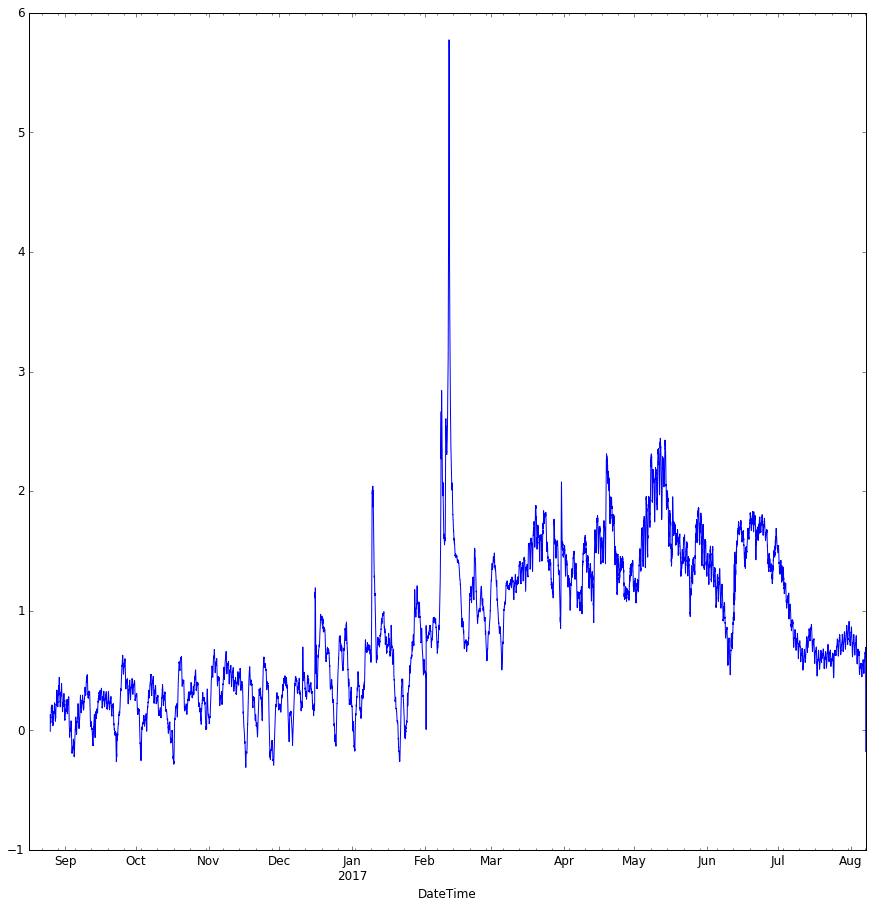

In [445]:
d['LowerMain'].plot()

Import and concatonate transducer data. Remove jumps and end (out of water) measurements. Remove na measurement values. Sort data.

In [446]:
token = "1ab92e63dd924c6189e6d5e1015c2645"
station = 'K36U'
token = "1ab92e63dd924c6189e6d5e1015c2645"
begdate = datetime.datetime.strftime(d.index[0],"%Y%m%d%H%M")
enddate = datetime.datetime.strftime(d.index[-1],"%Y%m%d%H%M")
addrs = 'https://api.mesowest.net/v2/stations/timeseries?token={:}&stid={:}&state=ut&start={:}&end={:}&units=pres|mb&output=csv'
html = addrs.format(token,station,begdate,enddate)
baro = pd.read_csv(html,skiprows=8,usecols=[1,2,15],index_col=0,parse_dates=True,names=['datetime','pressure_pascals','precip_mm'])


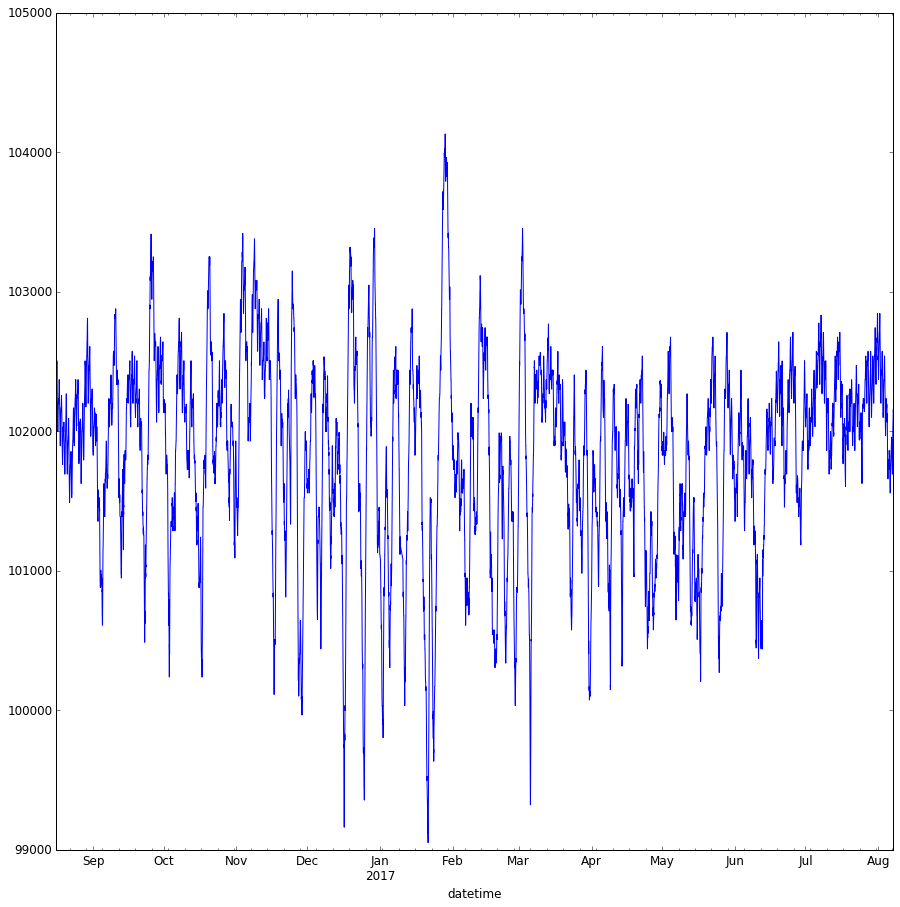

In [447]:
barores = baro.resample('1min').mean()
barores = barores.interpolate(how='time')
barores = barores.resample('15min').mean()
barores['pressure_pascals'].plot()
baro = pd.read_csv(html,skiprows=8,usecols=[1,2,15],index_col=0,parse_dates=True,names=['datetime','pressure_pascals','precip_in'])
baro = wa.transport.jumpfix(baro,'pressure_pascals',threashold=10000)
barores = wa.transport.hourly_resample(baro, minutes=60).shift(-6) #UTC to MDT
barores['baro (ft)'] = barores['pressure_pascals']*0.000334562

barores['StatBaro'] =barores['baro (ft)'] - (barores['baro (ft)'].mean()-d['Barometer'].mean())
bar = barores[[u'precip_in',u'StatBaro']]

dd = pd.merge(d,bar,right_index=True,left_index=True)

def fillB(x):
    if np.isnan(x[0]):
        return x[1]
    else:
        return x[0]

dd['Barometer'] = dd[['Barometer','StatBaro']].apply(lambda x: fillB(x),1)

Remove barometric pressure (non-vented transducers)

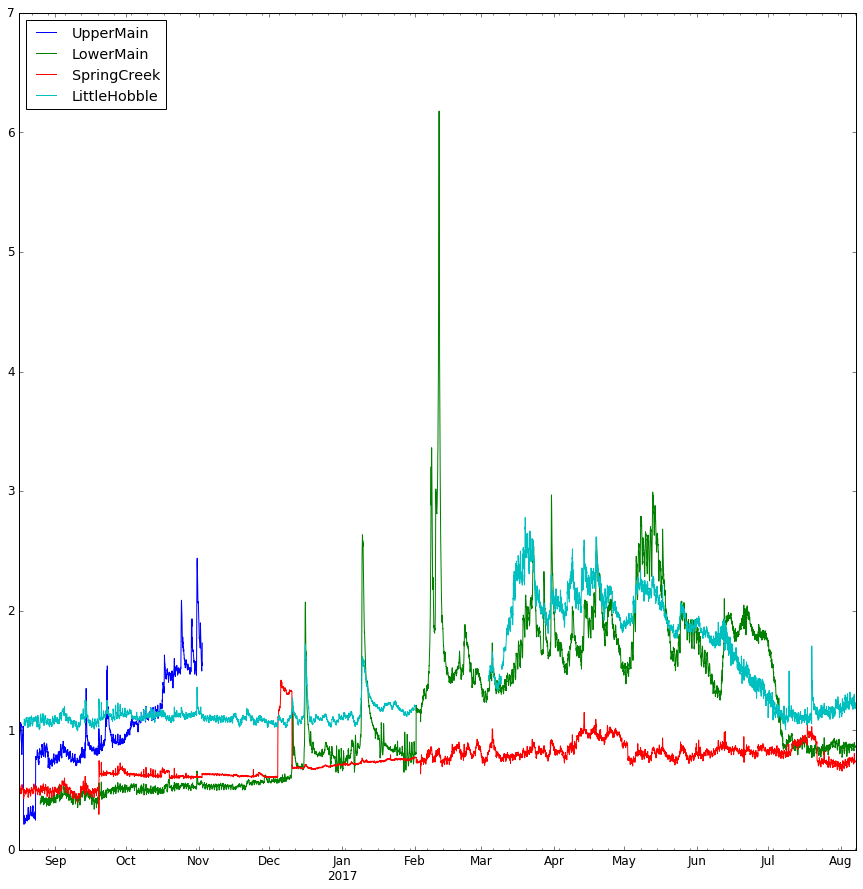

In [448]:
Qcolumns = [u'UpperMain', u'LowerMain', u'SpringCreek', u'LittleHobble']
# Reference determined using linear interpolation (intercept value); slope is 1.0

for i in range(len(Qcolumns)):
    dd['adj'+ Qcolumns[i]] = dd[[Qcolumns[i],'Barometer']].apply(lambda x: x[0] - (x[1]- 27.9889),1)
    dd['adj'+ Qcolumns[i]].plot(label=Qcolumns[i])

plt.legend(loc=2)
#plt.xlim('8/15/2016','11/2/2016')

Manually adjust jumps in data

In [450]:
dd.loc['2016-12-04 13:00:00':'2016-12-10 17:00:00','adjSpringCreek'] = None
dd.loc['2016-12-04 13:00:00':,'adjSpringCreek'] = dd.loc['2016-12-04 13:00:00':,'adjSpringCreek'] - 0.08
dd.loc['2016-09-19 13:00:00':,'adjSpringCreek'] = dd.loc['2016-09-19 13:00:00':,'adjSpringCreek'] - 0.14
dd.loc['2016-11-02 09:00:00':,'adjSpringCreek'] = dd.loc['2016-11-02 09:00:00':,'adjSpringCreek']- 0.025
#dd.loc['2017-07-21 19:00:00':,'adjSpringCreek']=dd.loc['2017-07-21 19:00:00':,'adjSpringCreek']+0.17
dd['adjSpringCreek'] = dd['adjSpringCreek'] - 0.08

dd.loc['2017-02-01 09:00:00':,'adjLowerMain'] = dd.loc['2017-02-01 09:00:00':,'adjLowerMain'] - 0.36

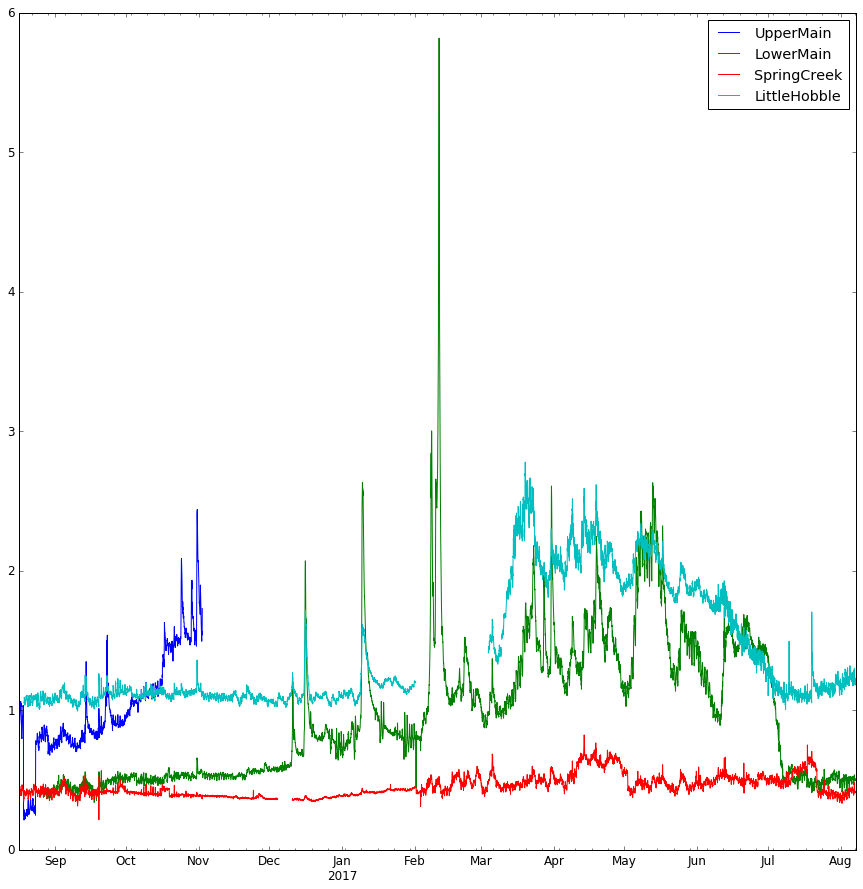

In [451]:
Qcolumns = [u'UpperMain', u'LowerMain', u'SpringCreek', u'LittleHobble']
# Reference determined using linear interpolation (intercept value); slope is 1.0

for i in range(len(Qcolumns)):
    dd['adj'+ Qcolumns[i]].plot(label=Qcolumns[i])
plt.legend()

### Little Hobble

[ 1.          3.7        -0.94034475]


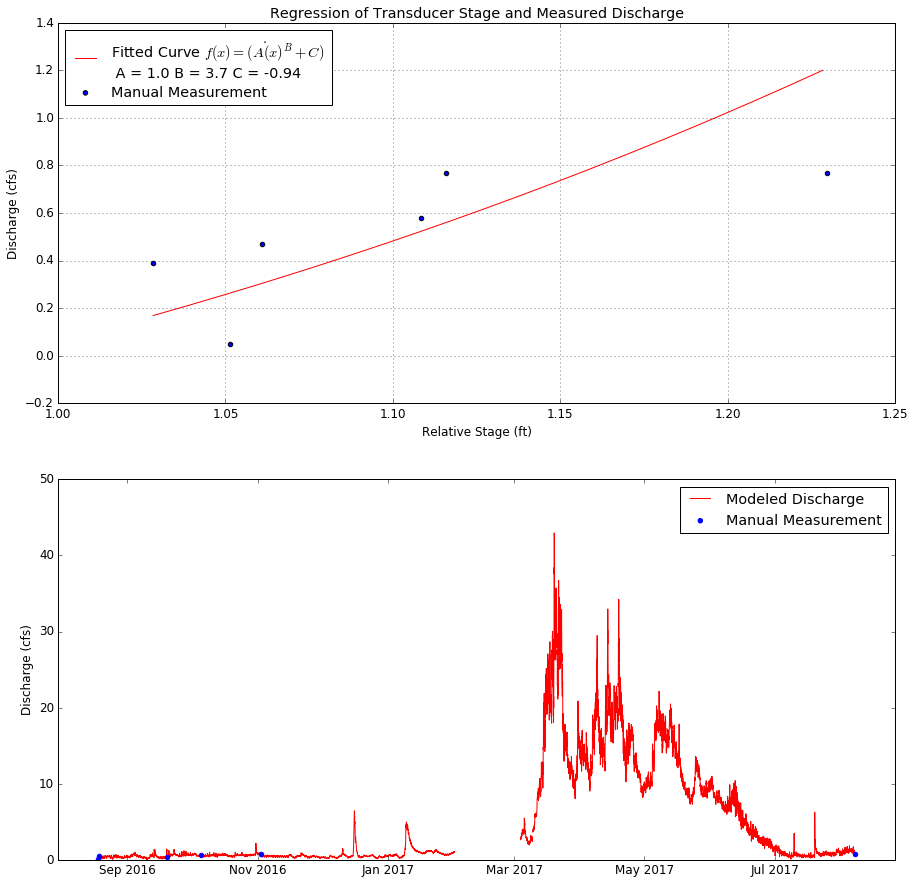

In [854]:
Qcolumns = [u'LittleHobble']
forks = [u'LittleHobble']
flow = pd.read_csv(fileplace+'ManualMeasurements.csv',index_col=0,parse_dates=True)
rcParams['figure.figsize'] = 15, 15
i=0

dfSub = dd['adj' + Qcolumns[i]].to_frame()
dfSub.dropna(inplace=True)
MFflow = flow[flow.Fork==forks[i]]
MFQ = []
for j in range(len(MFflow)):
    MFQ.append(wa.transport.fcl(dfSub, MFflow.index[j])['adj' + Qcolumns[i]])


x = MFQ
yn = MFflow.CFS

def func(x, a, b, c):
    return a*(x)**(b) + c

popt, pcov = curve_fit(func, x, yn, bounds = ([1.0,3.7,-10.0],[30.0,50.0,10.0]),
                      max_nfev=80000)

sterr = np.sqrt(np.diag(pcov))
print(popt)

gs = gridspec.GridSpec(2, 1)
rcParams['figure.figsize'] = 15, 15
plt.figure()
ax1 = plt.subplot(gs[0, 0])
ax1.set_title('Regression of Transducer Stage and Measured Discharge')
ax2 = plt.subplot(gs[1, 0])

ax1.scatter(x, yn, label='Manual Measurement')
xb = np.arange(np.min(x),np.max(x),0.01)
yb = [func(j, popt[0],popt[1],popt[2]) for j in xb]
equation = 'Fitted Curve ' + r'$f(x)= (A \dot (x)^{B} + C)$ '
eqlab = ' A = {:.2} B = {:.2} C = {:.2}'
ax1.plot(xb, yb, 'r-', label= equation+'\n'+eqlab.format(*popt))

ax1.legend(loc=2, scatterpoints=1)
ax1.grid()
ax1.set_ylabel('Discharge (cfs)')
ax1.set_xlabel('Relative Stage (ft)')

dd[forks[i] + '_cfs'] = dd['adj' + Qcolumns[i]].apply(lambda x: func(x, *popt), 1)


x = dd.index
y = dd[forks[i] + '_cfs']

x1 = MFflow.index
y1 = MFflow.CFS


ax2.plot(x,y,color='red',label='Modeled Discharge',zorder=0)
ax2.scatter(x1,y1,color='blue',label='Manual Measurement',zorder=1)
#plt.fill_between(x,dd[forks[i] + '_cfs_min'],dd[forks[i] + '_cfs_max'],alpha=0.5)
ax2.legend(scatterpoints=1)
ax2.set_ylabel('Discharge (cfs)')
ax2.set_ylim(0,50)
#ax2.title(forks[i])
plt.savefig(figplace + 'DischargeStage.svg')
plt.savefig(figplace + 'DischargeStage.pdf')


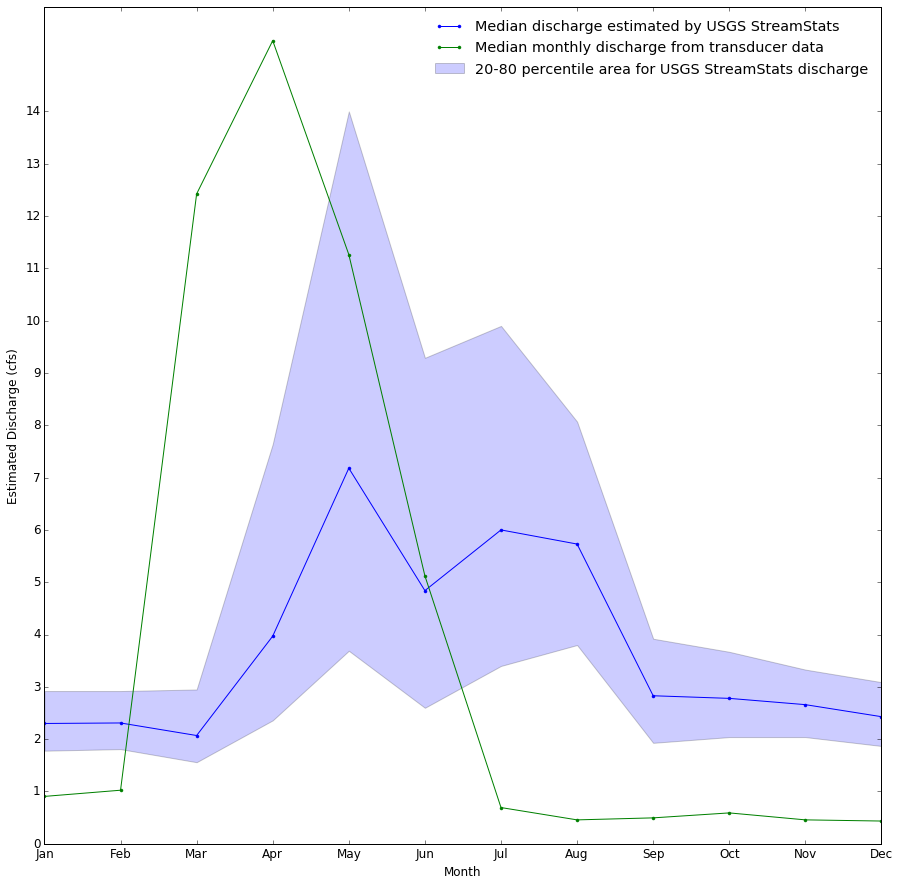

In [855]:
lh_stream_stats = pd.read_excel(fileplace+'LittleHobbleStreamStats.xlsx','Flows',index_col=[0,1])
lh_stream_stats.drop(['SEp'],inplace=True,axis=1)
lh_stream_stats=lh_stream_stats.unstack(level=-1)
lh_stream_stats.columns=lh_stream_stats.columns.droplevel(0)

plt.plot(lh_stream_stats.index,lh_stream_stats[50], '.-',label='Median discharge estimated by USGS StreamStats')
plt.fill_between(lh_stream_stats.index,lh_stream_stats[20],lh_stream_stats[80],alpha=0.20, label = '20-80 percentile area for USGS StreamStats discharge')
lhmed = dd['LittleHobble_cfs'].groupby(dd.index.month).median()
plt.plot(lhmed.index,lhmed,'.-',label='Median monthly discharge from transducer data')
plt.xlim(1,12)
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13),months)
plt.yticks(range(0,15))
plt.xlabel('Month')
plt.ylabel('Estimated Discharge (cfs)')
plt.legend(frameon=False)
plt.savefig(figplace+'StreamStatsComparison_LH.pdf')

([0.99693251533742333,
  0.99386503067484666,
  0.99079754601226999,
  0.98773006134969321,
  0.98466257668711654,
  0.98159509202453987,
  0.9785276073619632,
  0.97546012269938653,
  0.97239263803680986,
  0.96932515337423308,
  0.96625766871165641,
  0.96319018404907975,
  0.96012269938650308,
  0.95705521472392641,
  0.95398773006134974,
  0.95092024539877296,
  0.94785276073619629,
  0.94478527607361962,
  0.94171779141104295,
  0.93865030674846628,
  0.93558282208588961,
  0.93251533742331283,
  0.92944785276073616,
  0.92638036809815949,
  0.92331288343558282,
  0.92024539877300615,
  0.91717791411042948,
  0.91411042944785281,
  0.91104294478527603,
  0.90797546012269936,
  0.90490797546012269,
  0.90184049079754602,
  0.89877300613496935,
  0.89570552147239269,
  0.8926380368098159,
  0.88957055214723924,
  0.88650306748466257,
  0.8834355828220859,
  0.88036809815950923,
  0.87730061349693256,
  0.87423312883435578,
  0.87116564417177911,
  0.86809815950920244,
  0.8650306748

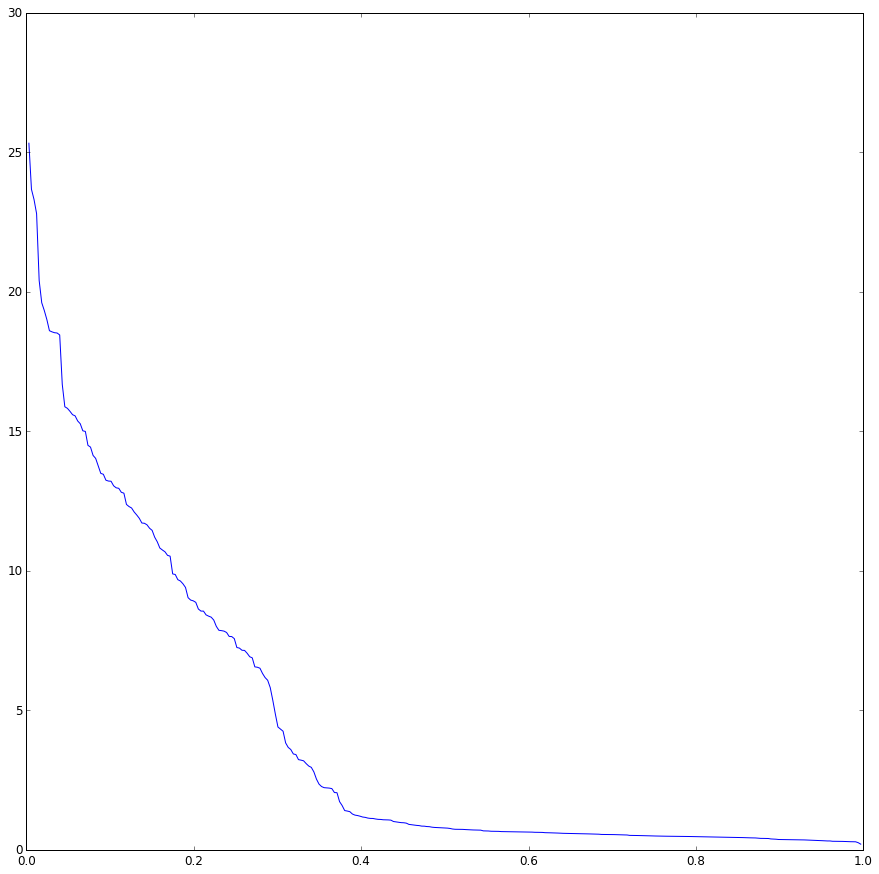

In [641]:
wa.fdc(dd,'LittleHobble_cfs',endyear=2018)

### Spring Creek (Wallsburg Spring)

http://www.tandfonline.com/doi/full/10.1080/19942060.2016.1157100

In [453]:
def culvertQ(depth, diam=22):
    colv = np.sqrt(32.2*(diam/12)**6)*0.716
    return (colv*0.5**(depth))*(depth)**2.175

culvertQ(.4)

2.586031111227471

In [654]:
sc_flow

Fork  staff gage       CFS
datetime                                              
2016-08-16 12:49:00  SpringCreek      0.0825  1.714458
2016-08-16 15:57:00  SpringCreek         NaN  2.000000
2016-08-17 15:40:00  SpringCreek      0.7900  1.840000
2016-09-19 11:50:00  SpringCreek      0.7750  1.810000
2016-09-28 10:43:00  SpringCreek         NaN  1.180000
2016-10-05 12:45:00  SpringCreek         NaN  1.810000
2016-11-02 10:30:00  SpringCreek      0.5000  1.610000
2017-08-07 10:30:00  SpringCreek         NaN  3.120000

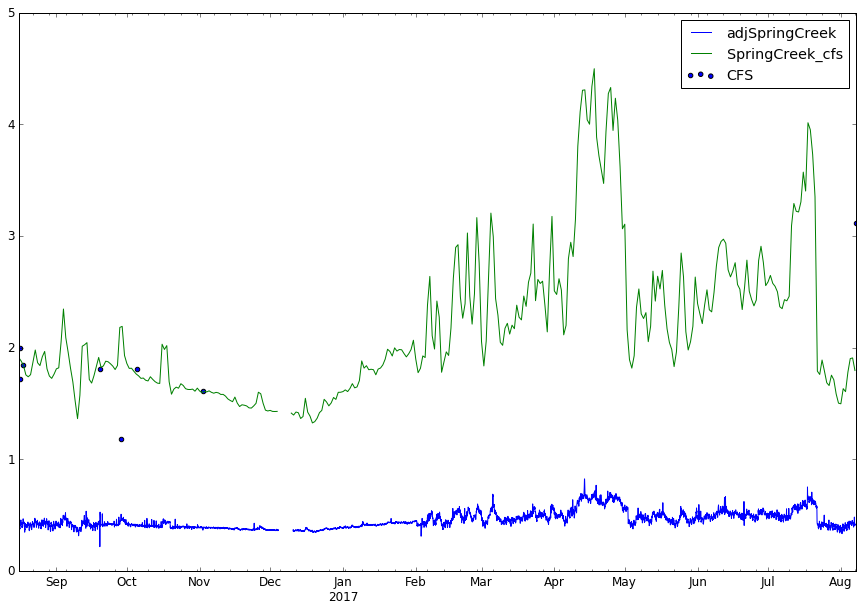

In [685]:
dd['adjSpringCreek'].plot()
dd['SpringCreek_cfs'] = dd['adjSpringCreek'].apply(lambda x: culvertQ(x, diam=19.15),1)
dd.groupby(pd.TimeGrouper('D'))['SpringCreek_cfs'].median().plot()
flow = pd.read_csv(fileplace+'ManualMeasurements.csv',index_col=0,parse_dates=True)
sc_flow = flow[flow.Fork == 'SpringCreek']
x = sc_flow.index
y = sc_flow.CFS

plt.scatter(x,y)
plt.legend()

### Lower Main Creek

Pull historic DEQ data

In [379]:
dans = pd.read_table(fileplace+'USGS_Dans_Crk.txt',usecols=[2,4],low_memory=False,
                     skiprows = 33, header=None, error_bad_lines=False,
                     dtype={'Agcny': np.str_,'Site': np.str_,'Datetime': np.str_,
                            'Timezone': np.str_,'FlowValue':np.float16,'Quality': np.str_},
                     names=['Agcny','Site','Datetime','Timezone','FlowValue','Quality'], 
                     memory_map=True
                    )
dans.set_index('Datetime',inplace=True)
dans.index = pd.to_datetime(dans.index)
dans.columns

Index(['FlowValue'], dtype='object')

Match DEQ flows to those in Daniel's Creek

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



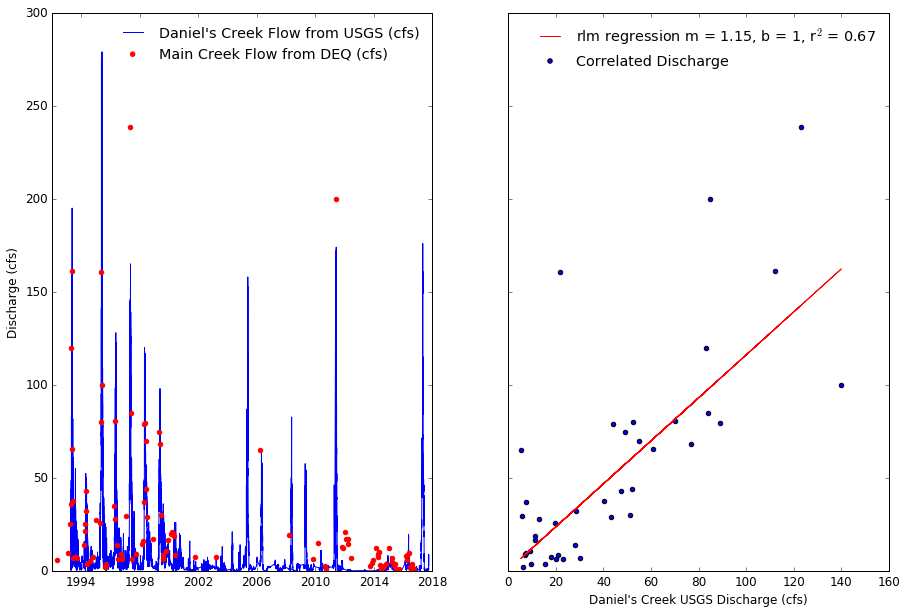

In [773]:
DEQ_long_flow = pd.read_excel(fileplace+'flow_check_wqp.xlsx','Sheet1')
DEQ_long_flow.set_index('datetime',inplace=True)
DEQ_long_flow.drop_duplicates(inplace=True)
matchflow = DEQ_long_flow[DEQ_long_flow.index >= pd.datetime(1993,4,15)]

dansflow = []

for i in matchflow.index:
    dansflow.append(wa.fcl(dans,i))
    
dansfl = pd.DataFrame(dansflow)
dansfl.index = pd.to_datetime(dansfl.index)


matchflow.loc[:,'dansQ'] = dansfl['FlowValue'].values
matchflow = matchflow[matchflow['dansQ']>5.0]
x = matchflow.index
x0 = matchflow['dansQ']
y = matchflow['Flow_cfs']

rcParams['figure.figsize'] = 15, 10
f, (ax1, ax2)  = plt.subplots(1, 2, sharey='row')

ax1.plot(dans.index,dans['FlowValue'],zorder=0, label='Daniel\'s Creek Flow from USGS (cfs)')
ax1.scatter(DEQ_long_flow.index,DEQ_long_flow['Flow_cfs'],color='red',zorder=1, label = 'Main Creek Flow from DEQ (cfs)')

ax1.set_xlim('1/1/1992','1/1/2018')

ax2.scatter(x0,y, label='Correlated Discharge')

xa = sm.add_constant(x0)
est = sm.RLM(y, xa).fit()
r2 = sm.WLS(y, xa, weights=est.weights).fit().rsquared
slope = est.params[1]
x_prime = np.linspace(np.min(x0), np.max(x0), 100)[:, np.newaxis]
x_prime = sm.add_constant(x_prime)
y_hat = est.predict(x_prime)

const = est.params[0]
x1 = np.arange(np.min(x0), np.max(x0), 0.1)
y2 = [i * slope + const for i in x0]

ax2.plot(x0, y2, c='r', label='rlm regression m = {:.2f}, b = {:.0f}, r$^2$ = {:.2f}'.format(slope, const, r2))
ax1.legend(scatterpoints=1,frameon=False)
ax2.set_xlim(0,160)
ax2.set_xlabel('Daniel\'s Creek USGS Discharge (cfs)')
plt.ylim(0,300)
ax1.set_ylabel('Discharge (cfs)')
ax2.legend(scatterpoints=1,frameon=False)
d2m_slope = slope
d2m_const = const
plt.savefig(figplace+'danscreekcorr.pdf')

Match Daniel's Creek to UGS Transducer Data

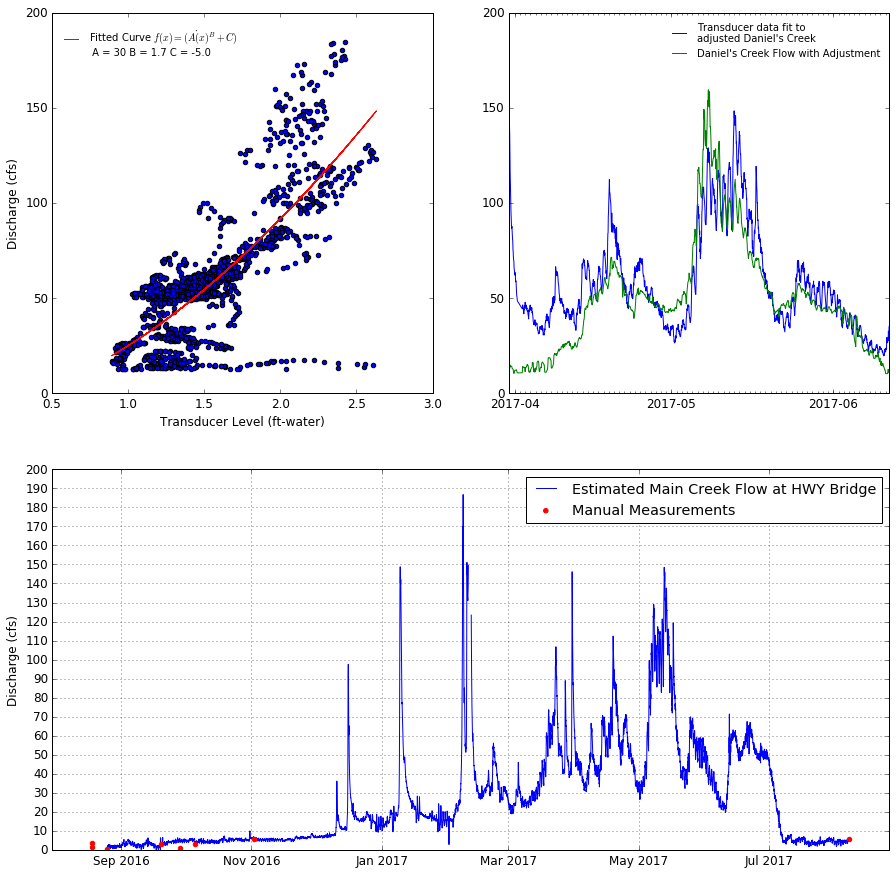

In [767]:
danshrly = dans.resample('1H').mean()
dansmatch = danshrly[(danshrly.index>=pd.datetime(2016,8,25,14))&(danshrly.index<=pd.datetime(2017,8,7,3))]
lmQ = dd.dropna(subset=['adjLowerMain'])['adjLowerMain'].to_frame().resample('1H').mean().interpolate()
lmQ['dans'] = dansmatch['FlowValue'].values
lmQ.dropna(inplace=True)
lmQ = lmQ[lmQ['dans']>10.0]
y = lmQ.dans
x = lmQ.adjLowerMain
w = lmQ.index.to_julian_date()

lmQ['Daniel\'s Creek Flow with Adjustment'] = lmQ['dans'] # rename for plot
yn = lmQ['Daniel\'s Creek Flow with Adjustment']*d2m_slope + d2m_const
x = lmQ['adjLowerMain']


def func(x, a, b, c):
    return a*(x)**(b) + c

bounds = ([0.75,1.0, -6.0],[30.0,10.0,-5.0])

popt, pcov = curve_fit(func, x, yn, bounds=bounds, max_nfev = 800000) #, method='trf')

sterr = np.sqrt(np.diag(pcov))


lal = 'Transducer data fit to\nadjusted Daniel\'s Creek'

equation = 'Fitted Curve ' + r'$f(x)= (A \dot (x)^{B} + C)$ '
eqlab = ' A = {:0.0f} B = {:0.1f} C = {:0.1f}'
lmQ[lal] = lmQ['adjLowerMain'].apply(lambda x: funclist[n](x,*popt),1)


#f, (ax1, ax2, ax3)  = plt.subplots(2, 2, sharey='row')

gs = gridspec.GridSpec(2, 2)
rcParams['figure.figsize'] = 15, 15
plt.figure()
ax1 = plt.subplot(gs[0, 0])

ax1.scatter(x,yn,label=None)
ax1.plot(x, [func(i,*popt) for i in x],color='red',label=equation+'\n'+eqlab.format(*popt))
ax1.set_xlabel('Transducer Level (ft-water)')
ax1.legend(loc=2,fontsize='small',scatterpoints=1,frameon=False)
ax1.set_ylabel('Discharge (cfs)')

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
ax2.plot(lmQ.index, lmQ[lal], label=lal)
ax2.plot(lmQ.index, lmQ['Daniel\'s Creek Flow with Adjustment'],label='Daniel\'s Creek Flow with Adjustment')
#lmQ[[lal,'Daniel\'s Creek Flow with Adjustment']].plot()
#plt.yscale('log')

#ax1.set_xticklabels(rotation=45)
months = mdates.MonthLocator() 
days = mdates.DayLocator()
monthsFmt = mdates.DateFormatter('%Y-%m')
ax2.xaxis.set_major_locator(months)
ax2.xaxis.set_major_formatter(monthsFmt)
ax2.xaxis.set_minor_locator(days)

ax2.legend(fontsize='small',frameon=False)


dd['LowerMain_cfs'] = dd['adjLowerMain'].apply(lambda x: func(x,*popt),1)
dd.loc['2017-02-10 12:00:00':'2017-02-11 18:00:00','LowerMain_cfs'] = None

flow = pd.read_csv(fileplace+'ManualMeasurements.csv',index_col=0,parse_dates=True)
mc_flow = flow[flow.Fork == 'LowerMain']

x = dd.index
y = dd['LowerMain_cfs']

x1 = mc_flow.index
y1 = mc_flow.CFS
#plt.figure()
ax3 = plt.subplot(gs[1, :])
ax3.plot(x,y,label='Estimated Main Creek Flow at HWY Bridge',zorder=0)

ax3.scatter(x1,y1,label='Manual Measurements',color='red',zorder=1)
ax3.set_ylim(0,200)
ax3.set_yticks(range(0,210,10))
ax3.grid()
#plt.yscale('log')
ax3.set_ylabel('Discharge (cfs)')
ax3.legend(scatterpoints=1)
plt.savefig(figplace+'MainCreekModel.pdf')

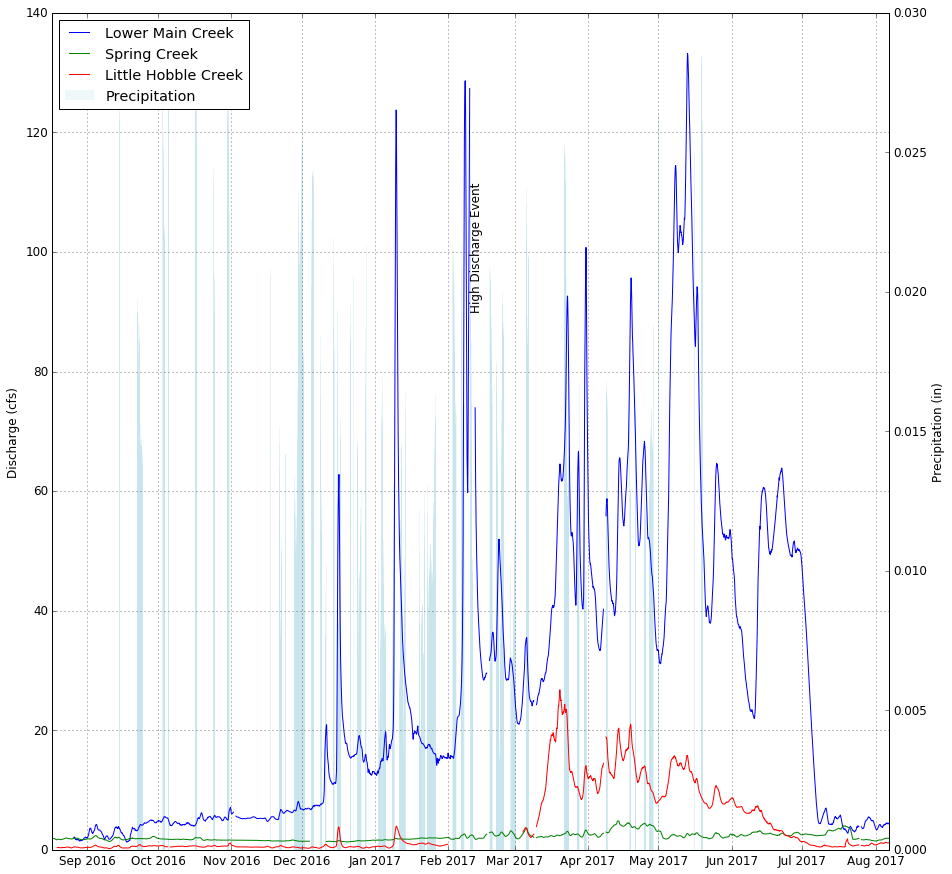

In [770]:
x0 = dd.index
#y1 = dd.UpperMain_cfs
y2 = dd.LowerMain_cfs.rolling(24, center=True).mean()
y3 = dd.SpringCreek_cfs.rolling(24, center=True).mean()
y4 = dd.LittleHobble_cfs.rolling(24, center=True).mean()
y5 = dd.precip_in.rolling(24, center=True).mean()*0.00001

ys = [y2,y3,y4]
ylabs = ['Lower Main Creek', 'Spring Creek','Little Hobble Creek']

fig, ax1 = plt.subplots()

n = 0
for y in ys:
    ax1.plot(x0,y,label=ylabs[n], zorder=n+1)
    n += 1
ax1.text('2/10/2017',110,'High Discharge Event',rotation=90)
ax2 = ax1.twinx()
ax1.bar(np.nan,np.nan, width=0.2, alpha=0.2,linewidth=0, zorder=0, color='lightblue',label='Precipitation')
ax2.bar(x0,y5, width=0.2, alpha=0.2,linewidth=0, zorder=0, color='lightblue')
ax1.set_zorder(ax2.get_zorder()+1) # put ax in front of ax2 
ax1.patch.set_visible(False) # hide the 'canvas' 

ax1.set_ylabel('Discharge (cfs)')
ax2.set_ylabel('Precipitation (in)')
ax1.legend(loc=2)
ax1.grid()
plt.savefig(figplace+'all_flows.pdf')

In [530]:
MainUSGS['value'].max()

152.0

6086.3249664


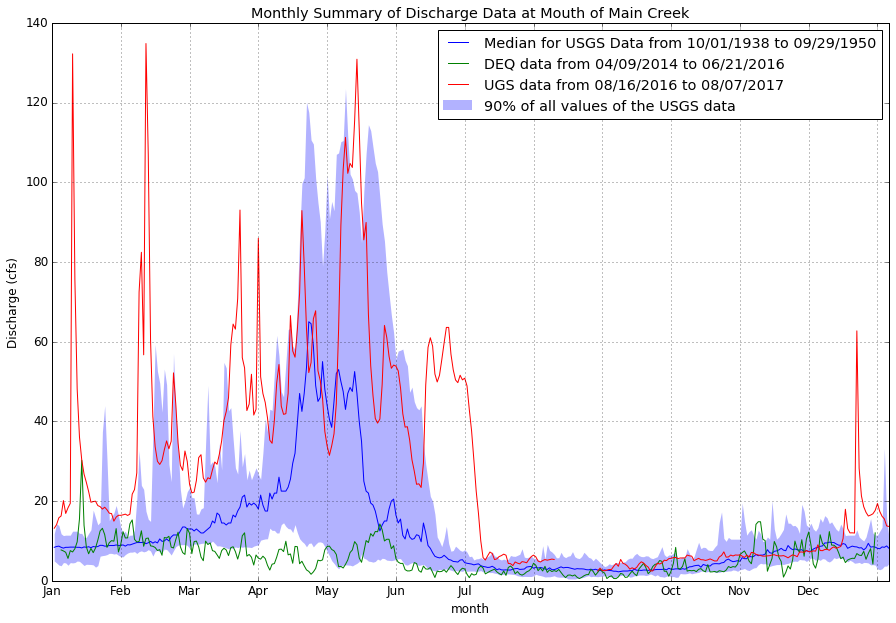

In [648]:
grpd = MainUSGS.groupby(['doy'])['value']
xm = grpd.median().index
ym = grpd.median()
x1 = grpd.quantile(q=0.05).index
y1 = grpd.quantile(q=0.05)
x2 = grpd.quantile(q=0.95).index
y2 = grpd.quantile(q=0.95)

DEQflClip['doy'] = DEQflClip.index.dayofyear
grpd2 = DEQflClip.groupby(['doy'])['flow']
xm2 = grpd2.median().index
ym2 = grpd2.median()

dd['doy'] = dd.index.dayofyear
grpd3 = dd.groupby(['doy'])['LowerMain_cfs']
x3 = grpd3.median().index
y3 = grpd3.median()
rcParams['figure.figsize'] = 15, 10

plt.plot(xm,ym, label='Median for USGS Data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(MainUSGS.index.min(),MainUSGS.index.max()))
plt.fill_between(x1,y1,y2,label='90% of all values of the USGS data',alpha=0.3,linewidth=0 )
plt.plot(xm2,ym2, label='DEQ data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(DEQflClip.index.min(),DEQflClip.index.max())) 
plt.plot(x3,y3, label = 'UGS data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(dd.index.min(),dd.index.max())) 

plt.title("Monthly Summary of Discharge Data at Mouth of Main Creek")

print(ym.median()*365.25*24*60*60*2.296E-5)
plt.legend()
plt.grid()

plt.xlabel('month')
dtrng = pd.date_range('1/1/2014','12/31/2014',freq='1M')
datelabels = [d.strftime('%b') for d in dtrng]
plt.xticks(range(0,365,30), datelabels)#dtrng)#,rotation=90)
plt.xlim(0,365)

plt.ylabel('Discharge (cfs)')
plt.savefig(figplace + 'MainCreekMonthlyHydroGraphAllData.svg')
plt.savefig(figplace + 'MainCreekMonthlyHydroGraphAllData.pdf')

USGS Flow Out: 8420 ac-ft/yr
DEQ Flow Out: 4028 ac-ft/yr
UGS Flow Out: 19438 ac-ft/yr


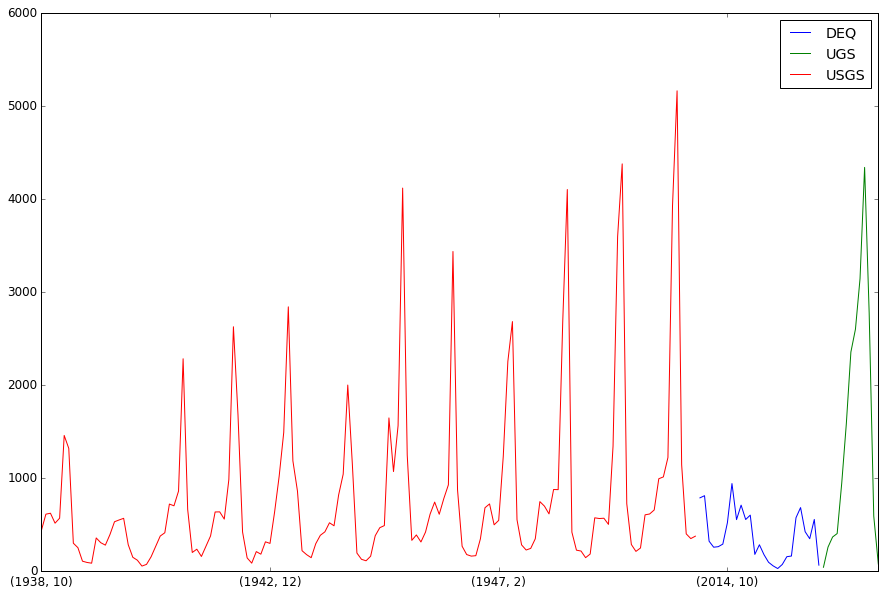

In [649]:
grpd = MainUSGS.groupby(['doy'])['value']

def get_stats(df,flow):
    grpd = df.groupby(['doy'])[flow] #cfs
    medQ = grpd.median()*86400.00 #cfd

    dailyQ = df.groupby(pd.TimeGrouper('D')).median()*86400.00 #cfd
    monQ = dailyQ.groupby([dailyQ.index.year,dailyQ.index.month])[flow].sum()*2.29569e-5 #ac-ft/mo
    yearQ = dailyQ.groupby(dailyQ.index.year)[flow].sum()*2.29569e-5 #ac-ft/year
    cumul = medQ.cumsum().values[-1] #cfyr
    return medQ, cumul, monQ, yearQ

datasets = [[MainUSGS,'value','USGS'],[DEQflClip,'flow','DEQ'],[dd,'LowerMain_cfs','UGS']]
medQ, sumQ, monQ, yrQ = {},{},{},{}
for i in datasets:
    medQ[i[2]],sumQ[i[2]],monQ[i[2]],yrQ[i[2]] = get_stats(i[0], i[1])
    print('{:} Flow Out: {:0.0f} ac-ft/yr'.format(i[2], sumQ[i[2]]*2.29569e-5))
yearlyQ = pd.DataFrame(yrQ)
monthlyQ = pd.DataFrame(monQ)
doymedQ = pd.DataFrame(medQ)
monthlyQ.plot()

In [550]:
lmugs = dd.dropna(subset=['LowerMain_cfs'])['LowerMain_cfs'].to_frame()


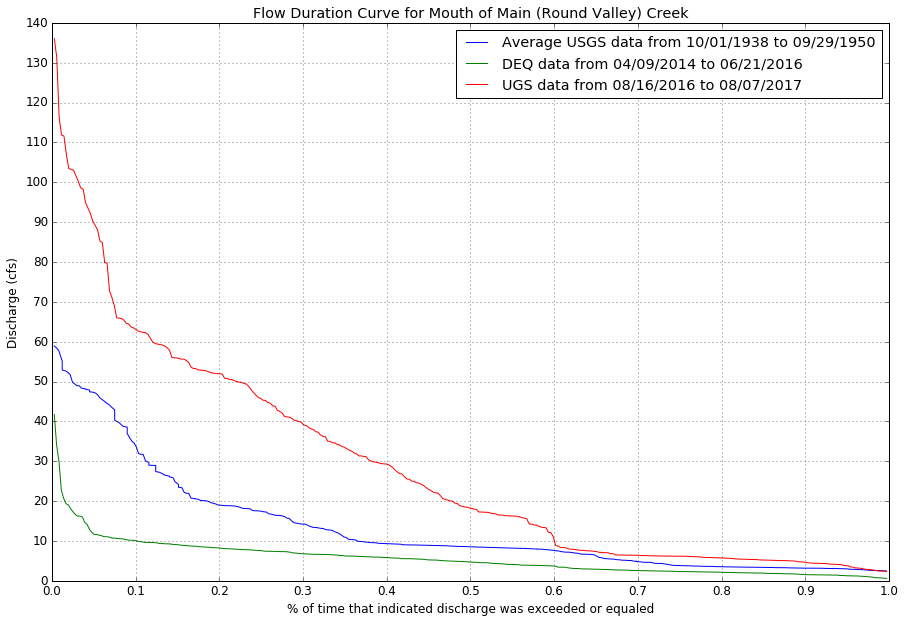

In [552]:
p1, d1, stdp1, stdm1, med1 = fdc_simple(MainUSGS,'value',plot=False)
p2, d2, stdp2, stdm2, med2 = fdc_simple(DEQflClip,'flow',plot=False)
p3, d3, stdp3, stdm3, med3 = fdc_simple(lmugs,'LowerMain_cfs',plot=False)

rcParams['figure.figsize'] = 15, 10
plt.title('Flow Duration Curve for Mouth of Main (Round Valley) Creek')
plt.plot(p1,d1,label='Average USGS data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(MainUSGS.index.min(),MainUSGS.index.max()))
plt.plot(p2,d2,label='DEQ data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(DEQflClip.index.min(),DEQflClip.index.max()))
plt.plot(p3,d3,label='UGS data from {:%m/%d/%Y} to {:%m/%d/%Y}'.format(dd.index.min(),dd.index.max()))
#plt.fill_between(p1,stdm1,stdp1,alpha=.3)
plt.grid()
plt.legend()
plt.ylabel('Discharge (cfs)')
plt.xlabel('% of time that indicated discharge was exceeded or equaled')
plt.xticks(np.arange(0,1.1,0.1))

plt.yticks(range(0,150,10))
plt.savefig(figplace + 'fdc_all_MainCreek.svg')
plt.savefig(figplace + 'fdc_all_MainCreek.pdf')

### Manual Data

In [ ]:
xlfile = r"H:\Google Drive\WORK\Round_Valley\Data\Hydrology_Data\Flow_Meas_Sites.xlsx"
SeepRun = xl2PntFt(xlfile, "X","Y",shpplace, 'SeepRun', 'MapData.gdb',4326)

<img src=http://i.ajdesigner.com/h/pipe_less.png>


<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/6daaf8ee00378e432eb6529c803344b3af6f43e6'>

In [ ]:
h = 0.4
R = 1.5
angle = 2*np.arccos(1-(h/R))
angle

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/390a83ea04c50c37e2bb2a9a75e2c674d517202d">

In [ ]:
c = 2*R*np.sin(angle/2)
c

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/c9ce62a002997277a68db1b9b75d26550025a4cf'>

In [ ]:
area = (R*R)/2*(angle-np.sin(angle))
area #ft sq
flow = 3.29 #ft/s
discharge = area*flow
print("the discharge is %f cfs" % discharge)

# PRISM

http://www.prism.oregonstate.edu/documents/PRISM_downloads_web_service.pdf


http://www.esrl.noaa.gov/psd/data/gridded/tables/precipitation.html

# Snotel

http://wcc.sc.egov.usda.gov/nwcc/site?sitenum=435

### hourly

In [ ]:
dt = datetime.today()
SNOTEL_hr_url = 'http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/hourly/435:UT:SNTL%7Cid=%22%22%7Cname/'+\
'2010-08-01,' + str(dt.year) + '-' + str(dt.month) + '-' +str(dt.day)+\
'/WTEQ::value,SNWD::value,PREC::value,TOBS::value,PRCP::value,SMS:-2:value,SMS:-8:value,SMS:-20:value'
SNTL_hr = pd.read_csv(SNOTEL_hr_url,skiprows=7,index_col='Date')

In [ ]:
SNTL_hr.columns

In [ ]:
SNTL_hr[u'Snow Water Equivalent (in)'].plot()

### Daily

In [ ]:
SNOTEL_dly_url = 'http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/customSingleStationReport/daily/'+\
'435:UT:SNTL%7Cid=%22%22%7Cname/1979-08-01,'+\
 str(dt.year) + '-' + str(dt.month) + '-' +str(dt.day)+\
'/WTEQ::value,SNWD::value,PREC::value,TOBS::value,PRCP::value,SMS:-2:value,SMS:-8:value,SMS:-20:value'
SNTL_dy = pd.read_csv(SNOTEL_dly_url,skiprows=7,index_col='Date')

In [ ]:
SNTL_dy 

# Potentiometric Surface Data

## UGS

### Levels

In [ ]:
UGSDTW = pd.read_excel(fileplace+'UGS_WL_Data.xlsx', index_col='Datetime')

In [ ]:
p1 = Proj(init='epsg:32612')
p2 = Proj(init='epsg:4326')
p3 = Proj(init='epsg:26912')

UGSDTW['dec_long_va'] = UGSDTW[['X','Y']].apply(lambda x: pyproj.transform(p1,p2,x[0],x[1])[0],1)
UGSDTW['dec_lat_va'] = UGSDTW[['X','Y']].apply(lambda x: pyproj.transform(p1,p2,x[0],x[1])[1],1)

UGSDTW['UTM_X'] = UGSDTW[['X','Y']].apply(lambda x: pyproj.transform(p1,p3,x[0],x[1])[0],1)
UGSDTW['UTM_Y'] = UGSDTW[['X','Y']].apply(lambda x: pyproj.transform(p1,p3,x[0],x[1])[1],1)
UGSDTW['DTW_FGS'] = UGSDTW[['DTW','Stickup']].apply(lambda x: x[0]-x[1],1)
UGSDTW['Elev'] = UGSDTW[['dec_long_va','dec_lat_va']].apply(lambda x: USGS.getelev(x),1)
UGSDTW['WL_Elev'] = UGSDTW[['DTW_FGS','Elev']].apply(lambda x: x[1]*3.2808-x[0],1)

def stupidUSGS(x):
    x = float(x)
    if x is None or x == np.NaN or x==np.nan or np.isnan(x):
        pass
    else:
        return str(int(float(x)))

UGSDTW['USGSnum'] = UGSDTW['USGSnum'].apply(lambda x: stupidUSGS(x),1)

In [ ]:
kml = simplekml.Kml()

wellstyle = simplekml.Style()
wellstyle.iconstyle.color = simplekml.Color.blue  # Make the text red
wellstyle.iconstyle.scale = 0.75  # Make the text twice as big
wellstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'


for i in list(UGSDTW.index):
    pnt = kml.newpoint()
    pnt.name = str(UGSDTW.ix[i,'ID'])
    pnt.description = str(UGSDTW.ix[i,'Name']) + ' ' + str(UGSDTW.ix[i,'WIN'])
    pnt.coords = [(UGSDTW.ix[i,'dec_long_va'], UGSDTW.ix[i,'dec_lat_va'])]
    pnt.style = wellstyle

kml.save(fileplace+"ugssites.kml")

In [ ]:
map_5 = folium.Map(location=[UGSDTW.dec_lat_va.median(), UGSDTW.dec_long_va.median()],tiles='Stamen Terrain',
                   zoom_start=13, width=u'100%', height=u'70%')

for i in range(len(UGSDTW)):
    
    folium.CircleMarker(
        [UGSDTW.ix[i,'dec_lat_va'],UGSDTW.ix[i,'dec_long_va']],
        popup=str(UGSDTW.ix[i,'Name']) + ' WL Elev:' + str(UGSDTW.ix[i,'WL_Elev']), color='#ff0000',
        radius=12
        ).add_to(map_5)

#map_5.click_for_marker(popup='Your Custom Text')
    
map_5



In [ ]:
UGSDTW.to_excel(fileplace+'UGS_WL_Data_out.xlsx')

### Screens

In [ ]:
UGSScrn = pd.read_excel(fileplace+'UGS_WL_Data.xlsx','screen')

In [ ]:
print(UGSDTW.columns)
print(UGSScrn.columns)

In [ ]:
ScrnEl = pd.merge(UGSScrn, UGSDTW, on='ID', how='left')

In [ ]:
ScrnEl['FromEl'] = ScrnEl['Elev']*3.2808 - ScrnEl['From_ft']
ScrnEl['ToEl'] = ScrnEl['Elev']*3.2808 - ScrnEl['To_ft']

### Gradient

In [ ]:
UGSGrad = xl2PntFt(fileplace+'UGS_WL_Data.xlsx', 'x2', 'y2', shpplace, 'UGSGrad', 'MapData.gdb',32612, sheetname='Vert_Gradient')

### UGS Data Create Feature Class

In [ ]:

    
shpnm = 'UGSWLS_utm1'
shpnm2 = 'UGSScrn_utm'
#df2PntShpAP(UGSDTW,'UTM_X','UTM_Y',shpplace + shpnm,26912)
df2PntShpAP(ScrnEl,'UTM_X','UTM_Y',shpplace + shpnm2,26912)
arcpy.env.workspace = fileplace
arcpy.FeatureClassToFeatureClass_conversion(shpplace + shpnm2 +'.shp', shpplace+'MapData.gdb', shpnm2)

## USGS

### Watershed-Wide USGS

The purpose of this section is to determine long-term variations in the regional groundwater levels, as well as produce a dataset to observe regional median groundwater levels.

First download all data from the Provo Watershed HUC.

In [ ]:
HUCName = {16020203:'Provo'}

USGSgwl = wa.nwis('gwlevels',16020203, 'huc')
allsites = USGSgwl.sites
alldata = USGSgwl.data
siteList = list(allsites.site_no.unique())
allsites.to_csv(fileplace+'usgs_well_locals.csv')
alldata.reset_index(inplace=True)
print('{:} measurements from {:} sites imported!'.format(len(alldata), len(allsites)))

In [ ]:
sitesinfo = USGSgwl.get_info()

In [ ]:
sites = get_station_info('16020203',sitetype='huc',datatype=['gw'])

Reproject USGS station data to local projection (NAD83 UTM Zone 12). Procure elevation from USGS service, based on the National Elevation Dataset, which generally has a 10-meter horizontal resolution and high vertical accuracy.

In [ ]:
p3 = Proj(init='epsg:26912') #NAD83 UTM Z12
p4 = Proj(init='epsg:4269') #NAD83 http://spatialreference.org/ref/epsg/4269/

allsites['UTM_X'] = allsites[['dec_long_va','dec_lat_va']].apply(lambda x: pyproj.transform(p4,p3,x[0],x[1])[0],1)
allsites['UTM_Y'] = allsites[['dec_long_va','dec_lat_va']].apply(lambda x: pyproj.transform(p4,p3,x[0],x[1])[1],1)
print('Reprojection Complete!')
allsites['Elev'] = allsites[['dec_long_va','dec_lat_va']].apply(lambda x: wa.get_elev(x),1)
print('Elevation assignment complete!')

In [ ]:
def get_huc(x):
    import requests
    """Receive the content of ``url``, parse it as JSON and return the object.
    :param x: [longitude, latitude]
    :returns: HUC12, HUC12_Name - 12 digit hydrologic unit code of location and the name associated with that code
    """
    values = {
        'geometry': '{:},{:}'.format(x[0], x[1]),
        'geometryType': 'esriGeometryPoint',
        'inSR': '4326',
        'spatialRel': 'esriSpatialRelIntersects',
        'returnGeometry': 'false',
        'outFields': 'HUC12,Name',
        'returnDistinctValues': 'true',
        'f': 'pjson'}

    huc_url = 'https://services.nationalmap.gov/arcgis/rest/services/wbd/MapServer/7/query?'
    # huc_url = 'https://services.nationalmap.gov/arcgis/rest/services/USGSHydroNHDLarge/MapServer/10/query?'
    # huc_url2 = 'https://services.nationalmap.gov/arcgis/rest/services/nhd/mapserver/8/query?'
    response = requests.get(huc_url, params=values).json()
    try:
        huc,name =  response['features'][0]['attributes']['HUC12'], response['features'][0]['attributes']['NAME']
    except KeyError:
        print("Key error for {:},{:}".format(x[0],x[1]))
        huc,name =  np.nan, np.nan
    return huc,name

In [ ]:
allsites['HUC12'] = allsites[['dec_long_va','dec_lat_va']].apply(lambda x: get_huc(x),1)

Count wells with multiple measurements.

In [ ]:
adg = alldata.groupby('site_no').size()
g = 0
h = 0
one = len(adg[adg == 1])
two = len(adg[adg == 2])
for i in range(max(adg)):
    if i > 30:
        g = g + len(adg[adg == i])
    elif i <= 30 and i > 1:
        h = h + len(adg[adg == i])

print("{:} of the {:} wells had 2 or more measurements. Of the {:} with 2 or more measurements \
{:} had just 2 and {:} had more than 30 measurements.".format(h+g, h + g + one, h + g, two, g))

In [ ]:
moretwo = list(adg[adg>2].index.values)
morethirty = list(adg[adg>30].index.values)

Normalize water level data by station so that changes at all stations can be compared.

In [ ]:
for site in siteList:
    mean = alldata.ix[alldata.site_no==site, 'value'].mean()
    std = alldata.ix[alldata.site_no==site, 'value'].std()
    meandiff = alldata.ix[alldata.site_no==site, 'value'].diff().mean()
    stddiff = alldata.ix[alldata.site_no==site, 'value'].diff().std()
    alldata.ix[alldata.site_no==site, 'diff'] = alldata.ix[alldata.site_no==site, 'value'].diff()
    alldata.ix[alldata.site_no==site, 'avgDiffWL'] = alldata.ix[alldata.site_no==site, 'value'] - mean
    alldata.ix[alldata.site_no==site, 'cdm'] = alldata.ix[alldata.site_no==site, 'avgDiffWL'].cumsum()
    alldata.ix[alldata.site_no==site, 'avgDiff_dWL'] = alldata.ix[alldata.site_no==site, 'diff'] - meandiff    
    alldata.ix[alldata.site_no==site, 'stdWL'] = alldata.ix[alldata.site_no==site, 'avgDiffWL']/std
    alldata.ix[alldata.site_no==site, 'std_dWL'] = alldata.ix[alldata.site_no==site, 'avgDiff_dWL']/stddiff

Prepare data for easy sorting and indexing.

In [ ]:
alldata.reset_index(inplace=True)
alldata['datetime'] = pd.to_datetime(alldata['datetime'])
alldata.set_index(['datetime'],inplace=True)

In [ ]:
#alldata.drop(['index'], axis=1, inplace=True)
alldata['year'] = alldata.index.year
alldata['month'] = alldata.index.month
alldata['doy'] = alldata.index.dayofyear
alldata['julian'] = alldata.index.to_julian_date()    

Pivot data to create a column for each site. Sort and resample.

In [ ]:
balldata = alldata.reset_index()
balldata.drop_duplicates(subset = ['site_no','datetime'], inplace=True)
provopivdata = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'stdWL').sort_index()
pivdataAll = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'value')
pivdataAll.sort_index(inplace=True)
pivdata = pivdataAll.resample('A').mean()

Plot availability of long-term depth to water measurements for Provo watershed. Summarized available measurements.

In [ ]:
SIZE = 11
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

gntAll = wa.gantt(pivdataAll)
infoAll = gntAll.sitestats #summary statistics for original data
gnt = wa.gantt(pivdata)
info = gnt.sitestats #summary statistics for annual data
infoless = info[info['count']>4] #select only sites having more than 4 years of data; non-consecutive, one sample per year
provolist = list(infoless.StationId.values)
df = alldata[alldata['site_no'].isin(provolist)]
print(len(provolist))
gntshort = wa.gantt(pivdata, provolist)
numsites = len(gntshort.sitestats)
rcParams['figure.figsize'] = 20, 20
gntshort.ganttPlotter() #plot data
plt.ylabel('USGS Site Number')
plt.xlim(pd.datetime(1935,1,1),pd.datetime(2017,1,1))
date_range = pd.date_range('1935-01-01', '2017-01-01', freq='36M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
plt.xticks(date_range)
plt.title('Measurement Intervals for USGS Wells in Provo Watershed')
plt.tight_layout()

plt.savefig(figplace+'ProvoGantt_long.pdf')

In [ ]:
dataXY = pd.merge(infoAll, allsites, right_on='site_no', left_on='StationId', how='left')
dataXY['WL_Elev'] = dataXY[['median','Elev']].apply(lambda x: x[1]*3.2808-x[0],1)

#df2PntFt(dataXY,'UTM_X','UTM_Y',shpplace,'USGS_Provo_Lev','MapData.gdb',26912)

In [ ]:
#infoless
sitesused = allsites

kml = simplekml.Kml()

wellstyle = simplekml.Style()
wellstyle.iconstyle.color = simplekml.Color.red  # Make the text red
wellstyle.iconstyle.scale = 0.5  # Make the text twice as big
wellstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'


for i in list(sitesused.index):
    pnt = kml.newpoint()
    pnt.name = str(sitesused.ix[i,'site_no'])
    pnt.description = str(sitesused.ix[i,'station_nm'])
    pnt.coords = [(sitesused.ix[i,'dec_long_va'], sitesused.ix[i,'dec_lat_va'])]
    pnt.style = wellstyle

kml.save(fileplace+"usgssites.kml")

Code below lumps data into 6 month intervals. As it is now, it has the potential to bias the levels to more-frequently monitored wells, which may or may not be representative of the system as a whole.

In [ ]:
grp = pd.TimeGrouper("12M")
data = 'stdWL'#'avgDiffWL'#'diff'#'std_dWL'
title = 'Average Difference from Mean Water Level (ft)'
wid = 4
cen = True

def confintpls(x):
    return np.mean(x)+(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

def confintmin(x):
    return np.mean(x)-(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

df = alldata[alldata['site_no'].isin(provolist)]

grpd = df.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

x2 = grpd.index
y2 = grpd['mean']
y3 = grpd['median']
snakegrp = grpd.median().to_frame()

SIZE = 11
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(x2, y3, '+-', color = 'green', label = 'Median' )
ax.plot(x2, y2, '+-', color = 'red', label = 'Average' )
ax.fill_between(x2,grpd['confmin'],grpd['confpls'],alpha=0.2,label='2 Standard Deviations',linewidth=0)

#ax1.set_ylim(3.5,-3.5)
ax.set_ylabel(title, color='red')
ax.invert_yaxis()
ax.grid()
ax2 = ax.twinx()
ax2.plot(x2,grpd['count'],label='Observations count')
ax2.set_ylim(0,1000)
ax2.set_yticks(range(0,420,20))
ax2.set_ylabel('Number of Observations',color='blue')
ax2.yaxis.set_label_coords(1.03,0.2)
ax.set_xlim(pd.datetime(1950,1,1),pd.datetime(2017,1,1))
date_range = pd.date_range('1950-01-01', '2017-01-01', freq='36M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
ax.set_xticks(date_range)
ax.set_xlabel('date')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.title('Average Deviation from Mean of Depth to Water for {:} Wells in the Provo Watershed (16020203)'.format(len(provolist)))
plt.savefig(figplace+'Provo_USGS_avg_stdev.pdf')

In [ ]:
grp = pd.TimeGrouper("12M")
data = 'avgDiffWL'#'diff'#'std_dWL'
title = 'Difference from Mean Water Level (ft)'
wid = 4
cen = True

def confintpls(x):
    return np.mean(x)+(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

def confintmin(x):
    return np.mean(x)-(np.std(x)*2.0)#/np.sqrt(np.size(x)))*1.96

df = alldata[alldata['site_no'].isin(provolist)]

grpd = df.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

x2 = grpd.index
y2 = grpd['mean']
y3 = grpd['median']
snakegrp = grpd.median().to_frame()

SIZE = 11
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(x2, y3, '+-', color = 'green', label = 'Median' )
ax.plot(x2, y2, '+-', color = 'red', label = 'Average' )
ax.fill_between(x2,grpd['confmin'],grpd['confpls'],alpha=0.2,label='2 Standard Deviations',linewidth=0)

#ax1.set_ylim(3.5,-3.5)
ax.set_ylabel(title, color='red')
ax.invert_yaxis()
ax.grid()
ax2 = ax.twinx()
ax2.plot(x2,grpd['count'],label='Observations count')
ax2.set_ylim(0,1000)
ax2.set_yticks(range(0,420,20))
ax2.set_ylabel('Number of Observations',color='blue')
ax2.yaxis.set_label_coords(1.03,0.2)
ax.set_xlim(pd.datetime(1950,1,1),pd.datetime(2017,1,1))
date_range = pd.date_range('1950-01-01', '2017-01-01', freq='36M')
date_range = date_range.map(lambda t: t.strftime('%Y-%m-%d'))
ax.set_xticks(date_range)
ax.set_xlabel('date')
# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.title('Deviation from Mean of Depth to Water for {:} Wells in the Provo Watershed (16020203)'.format(len(provolist)))
plt.savefig(figplace+'Provo_USGS_dev_avg.pdf')

In [ ]:
grp = 'month'
data = "avgDiffWL"
title = 'Average Difference from Mean Water Level (ft)'
wid = 4
cen = True
seas = alldata[alldata['site_no'].isin(moretwo)]

df1 = seas.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'std':np.std,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

SIZE = 14
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

plt.plot(df1.index,df1['mean'],'-o',label='Mean')
plt.plot(df1.index,df1['median'],'-o',label='Median')
medlist = df1['median'].values
for i in range(len(df1.index)):
    plt.text(df1.index[i],medlist[i]-3.2, 'n = ' + str(int(list(df1['count'].values)[i])),horizontalalignment='center')
plt.fill_between(df1.index,df1['mean']-df1['std']*1,df1['mean']+df1['std']*1,alpha=0.2,label='2 Standard Deviations')
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(0,13)
plt.xticks(range(1,13,1))
plt.legend()
plt.grid()
plt.xlabel('Month')
plt.ylabel( 'Average Difference from Mean Water Level (ft)')
plt.title('Monthly Average Difference from Mean Water Level in the Provo Watershed (16020203)')

plt.savefig(figplace+'Provo_USGS_Monthly_WL_diff_from_avg.pdf')

In [ ]:
grp = 'month'
data = "stdWL"
title = 'Average Standardized Water Level'
wid = 4
cen = True
seas = alldata[alldata['site_no'].isin(moretwo)]

df1 = seas.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'std':np.std,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

SIZE = 14
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

plt.plot(df1.index,df1['mean'],'-o',label='Mean')
plt.plot(df1.index,df1['median'],'-o',label='Median')
medlist = df1['median'].values
for i in range(len(df1.index)):
    plt.text(df1.index[i],medlist[i]-0.5, 'n = ' + str(int(list(df1['count'].values)[i])),horizontalalignment='center')
plt.fill_between(df1.index,df1['mean']-df1['std']*1,df1['mean']+df1['std']*1,alpha=0.2,label='2 Standard Deviations')
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(0,13)
plt.xticks(range(1,13,1))
plt.legend()
plt.grid()
plt.xlabel('Month')
plt.ylabel(title)
plt.title('Monthly Average Standardized Water Level in the Provo Watershed (16020203)')

plt.savefig(figplace+'Provo_USGS_Monthly_dev_stdAvg.pdf')

In [ ]:
gibb = pd.read_excel('H:/Google Drive/WORK/Round_Valley/Data/Hydrology_Data/Edwin Well - Sheet1.xlsx',index_col=0)

In [ ]:
gibb['month'] = gibb.index.month

In [ ]:
gibb['ft below ground'].plot()

In [ ]:
grp = 'month'
data = 'ft below ground'
title = 'Water Level (ft below ground surface)'
wid = 4
cen = True
seas = alldata[alldata['site_no'].isin(moretwo)]

df1 = gibb.groupby([grp])[data].agg({'median':np.median,'mean':np.mean,'std':np.std,'confpls':confintpls,'confmin':confintmin,'count':np.size})#,'confintmin':confintmin})

SIZE = 14
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

plt.plot(df1.index,df1['mean'],'-o',label='Mean')
plt.plot(df1.index,df1['median'],'-o',label='Median')
medlist = df1['median'].values
for i in range(len(df1.index)):
    plt.text(df1.index[i],medlist[i]-0.5, 'n = ' + str(int(list(df1['count'].values)[i])),horizontalalignment='center')
plt.fill_between(df1.index,df1['mean']-df1['std']*1,df1['mean']+df1['std']*1,alpha=0.2,label='2 Standard Deviations')
ax = plt.gca()
ax.invert_yaxis()
plt.xlim(0,13)
plt.xticks(range(1,13,1))
plt.legend()
plt.grid()
plt.xlabel('Month')
plt.ylabel(title)
plt.title('Monthly Average Standardized Water Level in the Gibbs Well')

plt.savefig(figplace+'Gibb_Monthly_dev_stdAvg.pdf')

### Round Valley USGS

USGS Water Level Data for Lat Long Box around Round Valley <br>
http://waterservices.usgs.gov/nwis/gwlevels/?format=rdb&bBox=-111.540000,40.260000,-111.250000,40.470000&startDT=1850-01-01&endDT=2016-08-21

USGS Water Level Site Data for Lat Long Box around Round Valley <br> http://waterservices.usgs.gov/nwis/site/?format=rdb,1.0&bBox=-111.540000,40.260000,-111.250000,40.470000&outputDataTypeCd=gw

In [ ]:
wlData_url = 'https://waterservices.usgs.gov/nwis/gwlevels/?format=rdb,1.0&bBox=-111.540000,40.260000,-111.250000,40.470000&startDT=1850-01-01&endDT=2016-08-21'
wlSiteData_url = 'https://waterservices.usgs.gov/nwis/site/?format=rdb,1.0&bBox=-111.540000,40.260000,-111.250000,40.470000&outputDataTypeCd=gw'
USGS_RV_Levels = USGS.getInfo(wlData_url)
USGS_RV_Sites = USGS.getInfo(wlSiteData_url)

In [ ]:
USGSrv = wa.nwis('gwlevels',[-111.540000,40.260000,-111.250000,40.470000], 'bBox')

In [ ]:
USGS_RV_Sites = USGSrv.sites

In [ ]:
USGS_RV_Levels = USGSrv.dataata

In [ ]:
USGS_RV_Sites['huc12'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: get_huc(x)[0],1)
USGS_RV_Sites['huc12_nm'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: get_huc(x)[1],1)

In [ ]:
HUCnames = {u'160202030402':'Little Hobble Creek',u'160202030403':'Upper Main Creek',u'160202030404':'Lower Main Creek',
            u'160202030405':'Deer Creek Reservoir-Provo River'}

In [ ]:
USGS_RV_Sites = USGS_RV_Sites[USGS_RV_Sites.huc12.isin([u'160202030403', u'160202030402', u'160202030404'])]
USGS_RV_Levels = USGS_RV_Levels[USGS_RV_Levels.index.get_level_values(0).isin(list(USGS_RV_Sites.site_no.unique()))]

In [ ]:
p3 = Proj(init='epsg:26912') #NAD83 UTM Z12
p4 = Proj(init='epsg:4269') #NAD83 http://spatialreference.org/ref/epsg/4269/

USGS_RV_Sites['UTM_X'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: pyproj.transform(p4,p3,x[0],x[1])[0],1)
USGS_RV_Sites['UTM_Y'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: pyproj.transform(p4,p3,x[0],x[1])[1],1)
print('Reprojection Complete!')
USGS_RV_Sites['Elev'] = USGS_RV_Sites[['dec_long_va','dec_lat_va']].apply(lambda x: wa.get_elev(x),1)
print('Elevation assignment complete!')

In [ ]:
USGS_RV_Levels = USGSrv.cleanGWL(USGS_RV_Levels)

In [ ]:
USGS_RV_Sites.set_index('site_no',inplace=True)

In [ ]:
stationWL = pd.merge(USGS_RV_Levels, USGS_RV_Sites, left_index=True, right_index=True, how='left')

In [ ]:
stationWL['wlelev'] = stationWL[['value','Elev']].apply(lambda x: x[1]-x[0],1)

In [ ]:
USGS_RV_Lev = USGS_RV_Levels.reset_index()
USGS_RV_Lev['lev_dt'] = pd.to_datetime(USGS_RV_Lev['datetime'])
USGS_RV_Lev.set_index(['lev_dt'],inplace=True)
#USGS_RV_Lev.drop(['index'], axis=1, inplace=True)
USGS_RV_Lev['year'] = USGS_RV_Lev.index.year
USGS_RV_Lev['month'] = USGS_RV_Lev.index.month
USGS_RV_Lev['doy'] = USGS_RV_Lev.index.dayofyear
USGS_RV_Lev['julian'] = USGS_RV_Lev.index.to_julian_date()

In [ ]:
balldata = USGS_RV_Lev.reset_index()
balldata.drop_duplicates(subset = ['site_no','datetime'], inplace=True)
snakepivdata = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'value').sort_index()
pivdata = balldata.pivot(index= 'datetime', columns = 'site_no', values = 'value')
pivdata.sort_index(inplace=True)
pivdata = pivdata.resample('M').mean()

In [ ]:
SIZE = 14
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

fig = wa.gantt(pivdata)
#fig.ganttPlotter()
info = fig.sitestats
infoless = info[info['count']>3]
snakelist = list(infoless.StationId.values)
df = balldata[balldata['site_no'].isin(snakelist)]
print(len(snakelist))
fig2 = wa.gantt(pivdata, snakelist)
fig2.ganttPlotter()
plt.ylabel('USGS Site Number')
plt.title('Measurement Intervals for USGS Wells in Round Valley')
plt.tight_layout()
plt.savefig(figplace+'RoundValleyGantt.pdf')

In [ ]:
USGS_RV_Sites.head()

In [ ]:
SIZE = 12
matplotlib.rc('font', size=SIZE)
matplotlib.rc('pdf', fonttype=42)

statList = infoless.StationId.values
f, ax = plt.subplots(len(statList), sharex=True)

for i in range(len(statList)):
    stLev = USGS_RV_Lev[USGS_RV_Lev['site_no']==statList[i]]
    stInf = USGS_RV_Sites[USGS_RV_Sites.index==statList[i]]
    
    ax[i].plot(stLev.index,stLev['value'],'o-')
    ax[i].invert_yaxis()
    ax[i].grid()
    ax[i].set_title('{:} in {:} area'.format(statList[i],stInf['huc12_nm'].values[0]))
f.text(-0.02,.5,'Depth to Water (ft)',ha='center', va='center', rotation='vertical', size='large')

plt.xlim(pd.datetime(1988,9,1),pd.datetime(1989,9,1))
date_rng = pd.date_range('1988-09-01', '1989-09-01', freq='1M')
date_range = date_rng.map(lambda t: t.strftime('%Y-%m-%d'))
date_labs = date_rng.map(lambda t: t.strftime('%Y-%m'))
plt.xticks(date_range,date_labs)
plt.tight_layout()


plt.savefig(figplace+'RoundValleySeasonal.pdf')

In [ ]:
kml = simplekml.Kml()

wellstyle = simplekml.Style()
wellstyle.iconstyle.color = simplekml.Color.red  # Make the text red
wellstyle.iconstyle.scale = 0.5  # Make the text twice as big
wellstyle.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'


for i in list(USGS_RV_Sites.index):
    pnt = kml.newpoint()
    pnt.name = str(USGS_RV_Sites.ix[i,'site_no'])
    pnt.description = str(USGS_RV_Sites.ix[i,'begin_date'])+', ' + str(USGS_RV_Sites.ix[i,'begin_date'])+', n = ' + str(USGS_RV_Sites.ix[i,'count_nu']) 
    pnt.coords = [(USGS_RV_Sites.ix[i,'dec_long_va'], USGS_RV_Sites.ix[i,'dec_lat_va'])]
    pnt.style = wellstyle

kml.save(fileplace+"usgs_rv_sites.kml")

In [ ]:
RV_Seasonal = USGS_RV_Sites[USGS_RV_Sites['site_no'].isin(statList)]
RV_Seasonal.columns

In [ ]:
RV_Seasonal.drop([u'agency_cd', u'site_tp_cd', u'coord_acy_cd', u'dec_coord_datum_cd', u'alt_va',
                  u'alt_acy_va', u'alt_datum_cd', u'huc_cd', u'data_type_cd', u'parm_cd',
                  u'stat_cd', u'ts_id', u'loc_web_ds', u'medium_grp_cd', u'parm_grp_cd',
                  u'srs_id', u'access_cd', u'begin_date', u'end_date', u'count_nu',
                  ], axis=1, inplace=True)

In [ ]:
RV_Seasonal

In [ ]:
RV_Seasonal

map_5 = folium.Map(location=[RV_Seasonal.dec_lat_va.median(), RV_Seasonal.dec_long_va.median()],tiles='Stamen Terrain',
                   zoom_start=13, width=u'100%', height=u'70%')

indnum = [3,5,27,32,34,35,38,43,48]

for i in range(len(RV_Seasonal)):
    
    folium.CircleMarker(
        [RV_Seasonal.ix[indnum[i],'dec_lat_va'],RV_Seasonal.ix[indnum[i],'dec_long_va']],
        popup=str(RV_Seasonal.ix[indnum[i],'site_no']), color='#ff0000',
        radius=12
        ).add_to(map_5)

#map_5.click_for_marker(popup='Your Custom Text')
    
map_5



In [ ]:
type(RV_Seasonal)

In [ ]:
ep = 26912
arcpy.env.workspace = shpplace+'MapData.gdb'

df2PntFt(RV_Seasonal,RV_Seasonal.UTM_X,RV_Seasonal.UTM_Y,shpplace,'SeasonalUSGS',shpplace+'MapData.gdb',ep)


In [ ]:
stationWL.lev_dt = stationWL.lev_dt.apply(lambda x: pd.to_datetime(x),1)

In [ ]:
map_6 = folium.Map(location=[USGS_RV_Sites.dec_lat_va.median(), USGS_RV_Sites.dec_long_va.median()],
                   tiles='Stamen Terrain',
                   zoom_start=13)
import vincent
for i in USGS_RV_Sites.index:
    vincent.core.initialize_notebook()
    num = USGS_RV_Sites.ix[i,'site_no']
    df = stationWL[stationWL.site_no == num]
    df.set_index(['lev_dt'],inplace=True)
    #print(df)
    line = vincent.Scatter([df.index.to_julian_date(), df['lev_va'].values])
    line.axis_titles(x='Date', y='Level (ft)')
    line.width = 200
    line.height = 100
    g =str(num) +'.json'
    line.to_json(g)
    folium.CircleMarker(
        [USGS_RV_Sites.ix[i,'dec_lat_va'], USGS_RV_Sites.ix[i,'dec_long_va']],
        popup= folium.Popup(max_width=450).add_child(
        folium.Vega(json.load(open(g)), width=250, height=150)),
        color='#ff0000', radius=12
        ).add_to(map_6)
map_6
